# LightGBM Advanced Diagnosis Classification

## Mục tiêu
- Sử dụng LightGBM với các kỹ thuật tiên tiến nhất
- Tối ưu hóa hyperparameter tự động với Optuna
- Hỗ trợ GPU và các cấu hình nâng cao
- Phân tích SHAP để giải thích mô hình
- Đánh giá mô hình toàn diện với nhiều metrics
- So sánh hiệu suất trên các dataset khác nhau


## 1. Environment Setup

### 🎯 Mục tiêu và Nguyên lý
Notebook này sử dụng LightGBM (Light Gradient Boosting Machine) - một thuật toán gradient boosting hiện đại với các ưu điểm:
- **Tốc độ cao**: Sử dụng Gradient-based One-Side Sampling (GOSS) và Exclusive Feature Bundling (EFB)
- **Hiệu quả bộ nhớ**: Xử lý dữ liệu lớn với ít RAM hơn so với XGBoost
- **Độ chính xác cao**: Có thể đạt performance tương đương hoặc tốt hơn các thuật toán khác
- **Tối ưu hóa tự động**: Sử dụng Optuna để tìm hyperparameters tối ưu mà không cần test thủ công


In [ ]:
# Kiểm tra và cài đặt các thư viện cần thiết tự động nếu chưa có
import sys
import subprocess
import platform

def install_and_import(package, import_name=None, pip_name=None):
    import importlib
    try:
        if import_name is None:
            import_name = package
        importlib.import_module(import_name)
    except ImportError:
        pip_pkg = pip_name if pip_name is not None else package
        print(f"Package '{pip_pkg}' not found. Installing...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_pkg])
            print(f"Installed '{pip_pkg}'.")
        except Exception as e:
            print(f"Error installing {pip_pkg}: {e}")
            print(f"Please try installing '{pip_pkg}' manually or check your environment.")
            # Optionally, raise the exception if installation is critical
            # raise e
    finally:
        try:
            # Try importing again after potential installation
            globals()[import_name if import_name else package] = importlib.import_module(import_name if import_name else package)
        except ImportError:
            print(f"Warning: Could not import {import_name if import_name else package} after installation attempt.")


# --- Cài đặt CUDA libraries và LightGBM với GPU support ---
print("🔧 Installing CUDA libraries and LightGBM with GPU support...")

# Bước 1: Cài đặt CUDA libraries cần thiết
print("1. Installing CUDA libraries...")
try:
    # Install CUDA libraries for CUDA 12.4
    cuda_libs = [
        "nvidia-cudnn-cu12",    # cuDNN for CUDA 12
        "nvidia-cublas-cu12",   # cuBLAS
        "nvidia-cufft-cu12",    # cuFFT
        "nvidia-curand-cu12",   # cuRAND
        "nvidia-cusparse-cu12", # cuSPARSE
        "nvidia-cusolver-cu12", # cuSOLVER
        "nvidia-nvtx-cu12",     # NVTX
        "nvidia-nccl-cu12",     # NCCL
        "nvidia-nvjitlink-cu12" # NVJITLINK
    ]
    
    for lib in cuda_libs:
        try:
            print(f"   Installing {lib}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", lib, "--no-deps", "--quiet"])
            print(f"   ✅ {lib} installed")
        except Exception as lib_e:
            print(f"   ⚠️ {lib} installation failed: {lib_e}")
    
    print("✅ CUDA libraries installation completed!")
    
    # Set CUDA environment variables
    import os
    os.environ['CUDA_HOME'] = '/usr/local/cuda'
    os.environ['CUDA_PATH'] = '/usr/local/cuda'
    os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')
    
    # Add Python package paths for CUDA libraries
    try:
        import site
        site_packages = site.getsitepackages()
        if site_packages:
            for sp in site_packages:
                cuda_lib_path = os.path.join(sp, 'nvidia', 'cuda_runtime', 'lib')
                if os.path.exists(cuda_lib_path):
                    os.environ['LD_LIBRARY_PATH'] = cuda_lib_path + ':' + os.environ.get('LD_LIBRARY_PATH', '')
                    print(f"   ✅ Added {cuda_lib_path} to LD_LIBRARY_PATH")
    except:
        pass
    
    print("✅ CUDA environment variables set!")
    
except Exception as e:
    print(f"⚠️ CUDA libraries installation warning: {e}")
    print("Continuing with LightGBM installation...")

# Bước 2: Cài đặt LightGBM với GPU support (Google Colab specific)
print("2. Installing LightGBM with GPU support for Google Colab...")
try:
    # Uninstall existing LightGBM first
    print("   Uninstalling existing LightGBM...")
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "lightgbm", "-y"])
    
    # Google Colab specific installation methods
    print("   Attempting LightGBM GPU installation for Google Colab...")
    
    # Method 1: Try lightgbm[gpu] (recommended for Colab)
    try:
        subprocess.check_call([
            sys.executable, "-m", "pip", "install",
            "lightgbm[gpu]"
        ])
        print("   ✅ LightGBM GPU installed via lightgbm[gpu]")
    except Exception as e1:
        print(f"   ⚠️ lightgbm[gpu] failed: {e1}")
        
        # Method 2: Try building from source with GPU support
        try:
            print("   Trying to build LightGBM from source with GPU support...")
            subprocess.check_call([
                sys.executable, "-m", "pip", "install",
                "lightgbm",
                "--config-settings=cmake.define.USE_GPU=ON",
                "--config-settings=cmake.define.USE_OPENCL=ON"
            ])
            print("   ✅ LightGBM GPU built from source")
        except Exception as e2:
            print(f"   ⚠️ Source build failed: {e2}")
            
            # Method 3: Try conda-forge GPU version
            try:
                subprocess.check_call([
                    sys.executable, "-m", "pip", "install",
                    "lightgbm",
                    "--index-url", "https://pypi.org/simple/",
                    "--extra-index-url", "https://conda.anaconda.org/conda-forge"
                ])
                print("   ✅ LightGBM installed via conda-forge")
            except Exception as e3:
                print(f"   ⚠️ Conda-forge failed: {e3}")
                
                # Method 4: Try pre-built GPU wheel
                try:
                    subprocess.check_call([
                        sys.executable, "-m", "pip", "install",
                        "lightgbm-gpu"
                    ])
                    print("   ✅ LightGBM GPU installed via lightgbm-gpu package")
                except Exception as e4:
                    print(f"   ⚠️ lightgbm-gpu failed: {e4}")
                    raise e4
    
    print("✅ LightGBM installation completed!")
    
except Exception as e:
    print(f"❌ LightGBM GPU installation failed: {e}")
    print("🔄 Falling back to CPU version...")
    try:
        # Fallback to CPU if GPU installation fails
        subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
        print("✅ LightGBM CPU version installed.")
    except Exception as cpu_e:
        print(f"❌ Error installing LightGBM CPU version: {cpu_e}")
        print("Please install LightGBM manually: pip install lightgbm")

# Import LightGBM after installation attempt
install_and_import("lightgbm", "lightgbm")

# Optuna
install_and_import("optuna", "optuna")
# Optuna-integration[lightgbm]
try:
    import optuna.integration.lightgbm
except ImportError:
    print("optuna-integration[lightgbm] not found. Installing...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna-integration[lightgbm]"])
        print("Installed 'optuna-integration[lightgbm]'.")
        import optuna.integration.lightgbm
    except Exception as e:
        print(f"Error installing optuna-integration[lightgbm]: {e}")
        print("Please install optuna-integration[lightgbm] manually: pip install optuna-integration[lightgbm]")


# SHAP
install_and_import("shap", "shap")

# Check if LightGBM is imported successfully
try:
    import lightgbm as lgb
    print(f"LightGBM version: {lgb.__version__}")
except ImportError:
    print("Error: LightGBM could not be imported. Please check your installation.")

🔧 Attempting to install LightGBM with GPU support...
✅ LightGBM with GPU support installed successfully!
LightGBM version: 4.6.0


In [ ]:
# SỬA LỖI CUDA LIBRARIES VÀ KIỂM TRA LIGHTGBM GPU THỰC SỰ
print("🔧 SỬA LỖI CUDA LIBRARIES VÀ KIỂM TRA LIGHTGBM GPU THỰC SỰ")
print("=" * 70)

import os
import subprocess
import glob

# 1. Cài đặt CUDA libraries cần thiết
print("1. CÀI ĐẶT CUDA LIBRARIES CẦN THIẾT:")
print("-" * 40)

cuda_libs = [
    "nvidia-cudnn-cu12",    # cuDNN for CUDA 12
    "nvidia-cublas-cu12",   # cuBLAS
    "nvidia-cufft-cu12",    # cuFFT
    "nvidia-curand-cu12",   # cuRAND
    "nvidia-cusparse-cu12", # cuSPARSE
    "nvidia-cusolver-cu12", # cuSOLVER
    "nvidia-nvtx-cu12",     # NVTX
    "nvidia-nccl-cu12",     # NCCL
    "nvidia-nvjitlink-cu12" # NVJITLINK
]

for lib in cuda_libs:
    try:
        print(f"   Installing {lib}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib, "--no-deps", "--quiet"])
        print(f"   ✅ {lib} installed")
    except Exception as e:
        print(f"   ⚠️ {lib} installation failed: {e}")

# 2. Set CUDA environment variables
print("\n2. SETTING CUDA ENVIRONMENT VARIABLES:")
print("-" * 40)

os.environ['CUDA_HOME'] = '/usr/local/cuda'
os.environ['CUDA_PATH'] = '/usr/local/cuda'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

# Add CUDA libraries to LD_LIBRARY_PATH
try:
    import site
    site_packages = site.getsitepackages()
    if site_packages:
        for sp in site_packages:
            cuda_lib_path = os.path.join(sp, 'nvidia', 'cuda_runtime', 'lib')
            if os.path.exists(cuda_lib_path):
                os.environ['LD_LIBRARY_PATH'] = cuda_lib_path + ':' + os.environ.get('LD_LIBRARY_PATH', '')
                print(f"   ✅ Added {cuda_lib_path} to LD_LIBRARY_PATH")
except:
    pass

print("   ✅ CUDA environment variables set!")

# 3. Kiểm tra lại CUDA libraries
print("\n3. KIỂM TRA LẠI CUDA LIBRARIES:")
print("-" * 40)

cuda_libs_check = ['cudart', 'cublas', 'curand', 'cufft']
check_paths = [
    '/usr/local/cuda/lib64',
    '/usr/local/cuda/lib',
    '/usr/lib/x86_64-linux-gnu',
    '/usr/lib64',
    '/usr/lib'
]

# Add Python package paths
try:
    import site
    site_packages = site.getsitepackages()
    if site_packages:
        check_paths.extend(site_packages)
except:
    pass

# Add LD_LIBRARY_PATH to check_paths
if 'LD_LIBRARY_PATH' in os.environ:
    check_paths.extend(os.environ['LD_LIBRARY_PATH'].split(':'))

print(f"   Checking {len(check_paths)} paths for CUDA libraries...")

for lib in cuda_libs_check:
    found = False
    found_paths = []
    
    for path in check_paths:
        if os.path.exists(path):
            for ext in ['.so', '.so.*', '.dll', '.dylib']:
                pattern = os.path.join(path, f'lib{lib}{ext}')
                if glob.glob(pattern):
                    found_paths.append(path)
                    found = True
    
    if found:
        print(f"   ✅ {lib}: Found in {len(found_paths)} locations")
        for p in found_paths[:2]:  # Show first 2 paths
            print(f"     - {p}")
    else:
        print(f"   ❌ {lib}: Still not found")

# Check if CUDA libraries are accessible via LD_LIBRARY_PATH
print("\n   Checking LD_LIBRARY_PATH for CUDA libraries...")
if 'LD_LIBRARY_PATH' in os.environ:
    ld_paths = os.environ['LD_LIBRARY_PATH'].split(':')
    print(f"   LD_LIBRARY_PATH: {ld_paths}")
    for path in ld_paths:
        if os.path.exists(path):
            cuda_libs_in_path = []
            for lib in cuda_libs_check:
                for ext in ['.so', '.so.*', '.dll', '.dylib']:
                    pattern = os.path.join(path, f'lib{lib}{ext}')
                    if glob.glob(pattern):
                        cuda_libs_in_path.append(lib)
                        break
            if cuda_libs_in_path:
                print(f"   ✅ Found CUDA libraries in {path}: {cuda_libs_in_path}")
else:
    print("   ❌ LD_LIBRARY_PATH not set")

# 4. Kiểm tra LightGBM GPU thực sự (Google Colab specific)
print("\n4. KIỂM TRA LIGHTGBM GPU THỰC SỰ (Google Colab specific):")
print("-" * 40)

try:
    import lightgbm as lgb
    import numpy as np  # Import numpy
    print(f"   LightGBM version: {lgb.__version__}")
    
    # Check if LightGBM was built with GPU support
    print("   Checking LightGBM build configuration...")
    try:
        # Try to get build info
        build_info = lgb.LGBMRegressor().get_params()
        print(f"   LightGBM parameters available: {len(build_info)}")
        
        # Check if GPU-related parameters are available
        gpu_params_available = any('gpu' in str(param).lower() for param in build_info.keys())
        print(f"   GPU parameters available: {gpu_params_available}")
        
    except Exception as build_e:
        print(f"   ⚠️ Could not check build info: {build_e}")
    
    # Create test data
    data = np.random.rand(1000, 10)
    label = np.random.randint(0, 2, 1000)
    train_data = lgb.Dataset(data, label=label)
    
    # Test different GPU parameter combinations for Google Colab
    gpu_test_configs = [
        {
            'name': 'Standard GPU config',
            'params': {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'device': 'gpu',
                'gpu_platform_id': 0,
                'gpu_device_id': 0,
                'verbose': 1,
                'num_leaves': 31,
                'learning_rate': 0.1,
                'num_boost_round': 5
            }
        },
        {
            'name': 'CUDA device config',
            'params': {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'device': 'cuda',
                'verbose': 1,
                'num_leaves': 31,
                'learning_rate': 0.1,
                'num_boost_round': 5
            }
        },
        {
            'name': 'OpenCL device config',
            'params': {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'device': 'opencl',
                'verbose': 1,
                'num_leaves': 31,
                'learning_rate': 0.1,
                'num_boost_round': 5
            }
        }
    ]
    
    gpu_working = False
    
    for config in gpu_test_configs:
        print(f"\n   Testing {config['name']}...")
        print(f"   Parameters: {config['params']}")
        print("   " + "="*50)
        
        try:
            # This should show GPU usage in output
            model = lgb.train(config['params'], train_data, num_boost_round=5)
            
            print("   " + "="*50)
            print(f"   ✅ {config['name']} test completed!")
            
            # Check if model actually used GPU
            if hasattr(model, 'booster_') and hasattr(model.booster_, 'get_params'):
                params = model.booster_.get_params()
                device_used = params.get('device', 'Not set')
                print(f"   Device used: {device_used}")
                
                if device_used in ['gpu', 'cuda', 'opencl']:
                    print(f"   ✅ {config['name']} confirmed to use GPU!")
                    gpu_working = True
                    break
                else:
                    print(f"   ⚠️ {config['name']} may not be using GPU")
            
        except Exception as test_e:
            print(f"   ❌ {config['name']} failed: {test_e}")
            continue
    
    if not gpu_working:
        print("\n   ⚠️ All GPU configurations failed. LightGBM may not have GPU support.")
        print("   💡 This is common on Google Colab. Consider using CPU or alternative libraries.")
    
    # Additional check: Try to get GPU memory info
    try:
        import subprocess
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            mem_used, mem_total = result.stdout.strip().split(', ')
            print(f"\n   📊 GPU Memory Usage: {mem_used}MB / {mem_total}MB")
            if int(mem_used) > 0:
                print("   ✅ GPU memory is being used!")
            else:
                print("   ⚠️ GPU memory not being used")
    except:
        pass
    
    # REAL GPU TEST - Test with larger dataset to force GPU usage
    print("\n   🔍 REAL GPU TEST - Testing with larger dataset...")
    print("   " + "="*60)
    
    try:
        # Create much larger dataset to force GPU usage
        print("   Creating large dataset (50,000 samples, 100 features)...")
        large_data = np.random.rand(50000, 100)
        large_label = np.random.randint(0, 2, 50000)
        large_train_data = lgb.Dataset(large_data, label=large_label)
        
        # Test with GPU
        gpu_params_large = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'verbose': 1,
            'num_leaves': 31,
            'learning_rate': 0.1,
            'num_boost_round': 10
        }
        
        print("   Testing with large dataset...")
        print("   Parameters:", gpu_params_large)
        
        # Monitor GPU before training
        result_before = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu', '--format=csv,noheader,nounits'], 
                                     capture_output=True, text=True, timeout=5)
        if result_before.returncode == 0:
            mem_before, util_before = result_before.stdout.strip().split(', ')
            print(f"   GPU before training: Memory {mem_before}MB, Utilization {util_before}%")
        
        # Train model
        model_large = lgb.train(gpu_params_large, large_train_data, num_boost_round=10)
        
        # Monitor GPU after training
        result_after = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu', '--format=csv,noheader,nounits'], 
                                    capture_output=True, text=True, timeout=5)
        if result_after.returncode == 0:
            mem_after, util_after = result_after.stdout.strip().split(', ')
            print(f"   GPU after training: Memory {mem_after}MB, Utilization {util_after}%")
            
            # Check if GPU was actually used
            mem_diff = int(mem_after) - int(mem_before)
            util_diff = int(util_after) - int(util_before)
            
            if mem_diff > 10 or util_diff > 0:
                print("   ✅ GPU was actually used! Memory increased by", mem_diff, "MB")
                print("   ✅ GPU utilization increased by", util_diff, "%")
            else:
                print("   ❌ GPU was NOT actually used. Memory change:", mem_diff, "MB")
                print("   ❌ GPU utilization change:", util_diff, "%")
                print("   💡 LightGBM is still using CPU despite device='gpu'")
        
    except Exception as e:
        print(f"   ❌ Large dataset test failed: {e}")
    
    print("   " + "="*60)
    
except Exception as e:
    print(f"   ❌ LightGBM GPU test failed: {e}")
    print("   💡 This indicates LightGBM cannot use GPU")

print("\n🎯 KẾT LUẬN:")
print("=" * 40)
print("Nếu bạn thấy 'GPU usage indicators' trong output trên, LightGBM đang sử dụng GPU.")
print("Nếu không, LightGBM vẫn đang fallback về CPU.")


In [ ]:
# MONITOR GPU USAGE TRONG QUÁ TRÌNH TRAINING THỰC TẾ
print("🔍 MONITOR GPU USAGE TRONG QUÁ TRÌNH TRAINING THỰC TẾ")
print("=" * 60)

import subprocess
import time
import threading
import numpy as np

def monitor_gpu_during_training(duration=60):
    """
    Monitor GPU usage during LightGBM training
    """
    print(f"🔍 Starting GPU monitoring for {duration} seconds...")
    print("Press Ctrl+C to stop monitoring")
    
    gpu_usage_detected = False
    
    try:
        for i in range(duration):
            result = subprocess.run([
                'nvidia-smi', 
                '--query-gpu=index,name,utilization.gpu,memory.used,memory.total,temperature.gpu,power.draw',
                '--format=csv,noheader,nounits'
            ], capture_output=True, text=True, timeout=5)
            
            if result.returncode == 0:
                lines = result.stdout.strip().split('\n')
                for line in lines:
                    if line.strip():
                        parts = line.split(', ')
                        if len(parts) >= 7:
                            gpu_id, name, util, mem_used, mem_total, temp, power = parts
                            
                            # Check if GPU is being used
                            if int(util) > 0 or int(mem_used) > 0:
                                gpu_usage_detected = True
                                print(f"🔥 [{i+1:3d}s] GPU {gpu_id} ACTIVE: {name} | Util: {util}% | Memory: {mem_used}/{mem_total}MB | Temp: {temp}°C | Power: {power}W")
                            else:
                                print(f"💤 [{i+1:3d}s] GPU {gpu_id} IDLE: {name} | Util: {util}% | Memory: {mem_used}/{mem_total}MB | Temp: {temp}°C | Power: {power}W")
            else:
                print(f"[{i+1:3d}s] nvidia-smi failed: {result.stderr}")
            
            time.sleep(1)
            
    except KeyboardInterrupt:
        print("\n🛑 GPU monitoring stopped by user")
    except Exception as e:
        print(f"\n❌ GPU monitoring error: {e}")
    
    return gpu_usage_detected

def test_lightgbm_gpu_with_monitoring():
    """
    Test LightGBM GPU with real-time monitoring
    """
    print("🧪 TESTING LIGHTGBM GPU WITH REAL-TIME MONITORING")
    print("=" * 50)
    
    try:
        import lightgbm as lgb
        import numpy as np  # Import numpy
        
        # Create larger test data to ensure GPU usage
        print("Creating test dataset...")
        data = np.random.rand(10000, 50)  # Larger dataset
        label = np.random.randint(0, 2, 10000)
        train_data = lgb.Dataset(data, label=label)
        
        # GPU parameters
        gpu_params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'verbose': 1,
            'num_leaves': 31,
            'learning_rate': 0.1,
            'num_boost_round': 100  # More rounds to see GPU usage
        }
        
        print("Starting LightGBM training with GPU...")
        print("GPU parameters:", gpu_params)
        print("\n" + "="*50)
        print("MONITORING GPU USAGE (check for GPU utilization > 0%)")
        print("="*50)
        
        # Start monitoring in background
        monitor_thread = threading.Thread(target=monitor_gpu_during_training, args=(120,))
        monitor_thread.daemon = True
        monitor_thread.start()
        
        # Train model
        model = lgb.train(gpu_params, train_data, num_boost_round=100)
        
        print("\n" + "="*50)
        print("TRAINING COMPLETED")
        print("="*50)
        
        # Check model parameters
        if hasattr(model, 'booster_') and hasattr(model.booster_, 'get_params'):
            params = model.booster_.get_params()
            print(f"Model device parameter: {params.get('device', 'Not set')}")
            
            if params.get('device') == 'gpu':
                print("✅ Model confirmed to use GPU!")
            else:
                print("⚠️ Model may not be using GPU despite device='gpu'")
        
        # Final GPU memory check
        try:
            result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total,utilization.gpu', '--format=csv,noheader,nounits'], 
                                  capture_output=True, text=True, timeout=5)
            if result.returncode == 0:
                mem_used, mem_total, gpu_util = result.stdout.strip().split(', ')
                print(f"📊 Final GPU Status: Memory {mem_used}MB/{mem_total}MB, Utilization {gpu_util}%")
                if int(mem_used) > 0 or int(gpu_util) > 0:
                    print("✅ GPU was actively used during training!")
                else:
                    print("⚠️ GPU was not actively used during training")
        except:
            pass
        
        return model
        
    except Exception as e:
        print(f"❌ LightGBM GPU test failed: {e}")
        return None

# Uncomment the line below to run the test
# test_lightgbm_gpu_with_monitoring()

print("💡 To test LightGBM GPU with monitoring, uncomment the last line and run this cell")
print("💡 This will show real-time GPU usage during training")

# ALTERNATIVE SOLUTIONS IF LIGHTGBM GPU DOESN'T WORK
print("\n" + "="*60)
print("🔄 ALTERNATIVE SOLUTIONS IF LIGHTGBM GPU DOESN'T WORK")
print("="*60)

print("""
If LightGBM GPU doesn't work on Google Colab, here are alternatives:

1. USE XGBOOST WITH GPU (Recommended):
   ```python
   !pip install xgboost[gpu]
   import xgboost as xgb
   
   # XGBoost GPU parameters
   params = {
       'tree_method': 'gpu_hist',
       'gpu_id': 0,
       'objective': 'binary:logistic'
   }
   ```

2. USE CATBOOST WITH GPU:
   ```python
   !pip install catboost
   import catboost as cb
   
   # CatBoost GPU parameters
   model = cb.CatBoostClassifier(
       task_type='GPU',
       devices='0'
   )
   ```

3. USE LIGHTGBM CPU (Fallback):
   ```python
   # LightGBM will automatically use CPU if GPU fails
   params = {
       'device': 'cpu',
       'objective': 'binary'
   }
   ```

4. USE PYTORCH LIGHTNING WITH GPU:
   ```python
   import torch
   import torch.nn as nn
   
   # PyTorch models can use GPU easily
   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   model = model.to(device)
   ```

5. MONITOR GPU USAGE:
   ```bash
   !nvidia-smi --loop=1
   ```
""")

print("💡 Google Colab often has issues with LightGBM GPU support.")
print("💡 XGBoost GPU is more reliable on Google Colab.")
print("💡 Consider using XGBoost if LightGBM GPU doesn't work.")

# FINAL SOLUTION: XGBoost GPU Implementation
print("\n" + "="*60)
print("🚀 FINAL SOLUTION: XGBOOST GPU IMPLEMENTATION")
print("="*60)

def install_and_test_xgboost_gpu():
    """
    Install and test XGBoost GPU as alternative to LightGBM
    """
    print("Installing XGBoost with GPU support...")
    
    try:
        # Install XGBoost with GPU support
        subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost[gpu]"])
        print("✅ XGBoost GPU installed successfully!")
        
        # Test XGBoost GPU
        import xgboost as xgb
        print(f"XGBoost version: {xgb.__version__}")
        
        # Create test data
        data = np.random.rand(10000, 50)
        label = np.random.randint(0, 2, 10000)
        
        # XGBoost GPU parameters
        params = {
            'tree_method': 'gpu_hist',
            'gpu_id': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100
        }
        
        print("Testing XGBoost GPU...")
        print("Parameters:", params)
        
        # Monitor GPU before training
        result_before = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu', '--format=csv,noheader,nounits'], 
                                     capture_output=True, text=True, timeout=5)
        if result_before.returncode == 0:
            mem_before, util_before = result_before.stdout.strip().split(', ')
            print(f"GPU before training: Memory {mem_before}MB, Utilization {util_before}%")
        
        # Train XGBoost model
        model = xgb.XGBClassifier(**params)
        model.fit(data, label)
        
        # Monitor GPU after training
        result_after = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu', '--format=csv,noheader,nounits'], 
                                    capture_output=True, text=True, timeout=5)
        if result_after.returncode == 0:
            mem_after, util_after = result_after.stdout.strip().split(', ')
            print(f"GPU after training: Memory {mem_after}MB, Utilization {util_after}%")
            
            # Check if GPU was actually used
            mem_diff = int(mem_after) - int(mem_before)
            util_diff = int(util_after) - int(util_before)
            
            if mem_diff > 10 or util_diff > 0:
                print("✅ XGBoost GPU was actually used! Memory increased by", mem_diff, "MB")
                print("✅ XGBoost GPU utilization increased by", util_diff, "%")
                return True
            else:
                print("❌ XGBoost GPU was NOT actually used. Memory change:", mem_diff, "MB")
                print("❌ XGBoost GPU utilization change:", util_diff, "%")
                return False
        
    except Exception as e:
        print(f"❌ XGBoost GPU test failed: {e}")
        return False

# Uncomment the line below to test XGBoost GPU
# install_and_test_xgboost_gpu()

print("\n💡 To test XGBoost GPU, uncomment the last line and run this cell")
print("💡 XGBoost GPU is more reliable than LightGBM GPU on Google Colab")

# TỐI ƯU HÓA GPU USAGE - TẬN DỤNG TỐI ĐA GPU
print("\n" + "="*60)
print("🚀 TỐI ƯU HÓA GPU USAGE - TẬN DỤNG TỐI ĐA GPU")
print("="*60)

def optimize_lightgbm_gpu_usage():
    """
    Tối ưu hóa LightGBM để tận dụng tối đa GPU
    """
    print("🔧 TỐI ƯU HÓA LIGHTGBM GPU USAGE")
    print("="*50)
    
    try:
        import lightgbm as lgb
        import numpy as np
        import time
        
        # Tạo dataset lớn để tận dụng GPU
        print("1. Tạo dataset lớn để tận dụng GPU...")
        n_samples = 100000  # Tăng từ 50,000 lên 100,000
        n_features = 200    # Tăng từ 100 lên 200
        data = np.random.rand(n_samples, n_features)
        label = np.random.randint(0, 2, n_samples)
        train_data = lgb.Dataset(data, label=label)
        
        print(f"   Dataset size: {n_samples:,} samples x {n_features} features")
        print(f"   Memory usage: ~{n_samples * n_features * 8 / 1024**2:.1f} MB")
        
        # Cấu hình tối ưu cho GPU
        print("\n2. Cấu hình tối ưu cho GPU...")
        optimized_params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'verbose': 1,
            
            # Tối ưu cho GPU
            'num_leaves': 255,        # Tăng từ 31 lên 255
            'max_depth': 15,          # Tăng depth
            'min_data_in_leaf': 20,   # Giảm để tận dụng GPU
            'min_sum_hessian_in_leaf': 1e-3,
            
            # Feature và bagging
            'feature_fraction': 0.8,  # Sử dụng 80% features
            'bagging_fraction': 0.8,  # Sử dụng 80% samples
            'bagging_freq': 5,
            
            # Learning parameters
            'learning_rate': 0.1,
            'num_boost_round': 100,   # Tăng số rounds
            
            # GPU specific
            'gpu_use_dp': True,       # Sử dụng double precision
            'force_col_wise': True,   # Tối ưu cho GPU
        }
        
        print("   Optimized parameters:")
        for key, value in optimized_params.items():
            print(f"     {key}: {value}")
        
        # Monitor GPU trước training
        print("\n3. Monitor GPU trước training...")
        result_before = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu,power.draw', '--format=csv,noheader,nounits'], 
                                     capture_output=True, text=True, timeout=5)
        if result_before.returncode == 0:
            mem_before, util_before, power_before = result_before.stdout.strip().split(', ')
            print(f"   GPU trước training: Memory {mem_before}MB, Utilization {util_before}%, Power {power_before}W")
        
        # Training với cấu hình tối ưu
        print("\n4. Training với cấu hình tối ưu...")
        start_time = time.time()
        
        model = lgb.train(optimized_params, train_data, num_boost_round=100)
        
        end_time = time.time()
        training_time = end_time - start_time
        
        print(f"   Training time: {training_time:.2f} seconds")
        
        # Monitor GPU sau training
        print("\n5. Monitor GPU sau training...")
        result_after = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu,power.draw', '--format=csv,noheader,nounits'], 
                                    capture_output=True, text=True, timeout=5)
        if result_after.returncode == 0:
            mem_after, util_after, power_after = result_after.stdout.strip().split(', ')
            print(f"   GPU sau training: Memory {mem_after}MB, Utilization {util_after}%, Power {power_after}W")
            
            # Tính toán hiệu quả
            mem_diff = int(mem_after) - int(mem_before)
            util_diff = int(util_after) - int(util_before)
            power_diff = float(power_after) - float(power_before)
            
            print(f"\n   📊 HIỆU QUẢ GPU:")
            print(f"     Memory tăng: {mem_diff}MB")
            print(f"     Utilization tăng: {util_diff}%")
            print(f"     Power tăng: {power_diff:.1f}W")
            
            if mem_diff > 50:
                print("     ✅ GPU memory được sử dụng hiệu quả!")
            if util_diff > 10:
                print("     ✅ GPU utilization cao!")
            if power_diff > 5:
                print("     ✅ GPU power consumption cao - đang hoạt động tích cực!")
        
        # Performance metrics
        print(f"\n6. Performance metrics:")
        print(f"   Samples per second: {n_samples / training_time:.0f}")
        print(f"   Features processed: {n_features * n_samples / training_time:.0f} per second")
        print(f"   GPU efficiency: {mem_diff / 15 * 100:.1f}% of total GPU memory")
        
        return model
        
    except Exception as e:
        print(f"❌ Optimization failed: {e}")
        return None

def compare_cpu_vs_gpu_performance():
    """
    So sánh performance giữa CPU và GPU
    """
    print("\n" + "="*60)
    print("⚡ SO SÁNH PERFORMANCE CPU vs GPU")
    print("="*60)
    
    try:
        import lightgbm as lgb
        import numpy as np
        import time
        
        # Tạo dataset test
        n_samples = 50000
        n_features = 100
        data = np.random.rand(n_samples, n_features)
        label = np.random.randint(0, 2, n_samples)
        train_data = lgb.Dataset(data, label=label)
        
        print(f"Test dataset: {n_samples:,} samples x {n_features} features")
        
        # CPU configuration
        cpu_params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'device': 'cpu',
            'verbose': 0,
            'num_leaves': 31,
            'learning_rate': 0.1,
            'num_boost_round': 50
        }
        
        # GPU configuration
        gpu_params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'verbose': 0,
            'num_leaves': 31,
            'learning_rate': 0.1,
            'num_boost_round': 50
        }
        
        # Test CPU
        print("\n1. Testing CPU performance...")
        start_time = time.time()
        cpu_model = lgb.train(cpu_params, train_data, num_boost_round=50)
        cpu_time = time.time() - start_time
        print(f"   CPU time: {cpu_time:.2f} seconds")
        
        # Test GPU
        print("\n2. Testing GPU performance...")
        start_time = time.time()
        gpu_model = lgb.train(gpu_params, train_data, num_boost_round=50)
        gpu_time = time.time() - start_time
        print(f"   GPU time: {gpu_time:.2f} seconds")
        
        # So sánh
        speedup = cpu_time / gpu_time
        print(f"\n3. Performance comparison:")
        print(f"   CPU time: {cpu_time:.2f}s")
        print(f"   GPU time: {gpu_time:.2f}s")
        print(f"   Speedup: {speedup:.2f}x faster with GPU")
        
        if speedup > 1.5:
            print("   ✅ GPU provides significant speedup!")
        elif speedup > 1.1:
            print("   ⚠️ GPU provides modest speedup")
        else:
            print("   ❌ GPU not providing speedup - may be using CPU")
        
    except Exception as e:
        print(f"❌ Comparison failed: {e}")

# MAXIMIZE GPU VRAM USAGE - SỬ DỤNG TỐI ĐA 15GB VRAM
print("\n" + "="*60)
print("🔥 MAXIMIZE GPU VRAM USAGE - SỬ DỤNG TỐI ĐA 15GB VRAM")
print("="*60)

def maximize_gpu_vram_usage():
    """
    Tối ưu hóa để sử dụng tối đa 15GB VRAM
    """
    print("🚀 MAXIMIZE GPU VRAM USAGE")
    print("="*50)
    
    try:
        import lightgbm as lgb
        import numpy as np
        import time
        
        # Tạo dataset cực lớn để sử dụng tối đa VRAM
        print("1. Tạo dataset cực lớn để sử dụng tối đa VRAM...")
        
        # Tính toán kích thước dataset để sử dụng ~12GB VRAM
        # Mỗi sample với 500 features = ~4KB
        # 12GB = 12,000MB = 12,000,000KB
        # 12,000,000KB / 4KB = 3,000,000 samples
        n_samples = 2000000  # 2 triệu samples
        n_features = 500     # 500 features
        data = np.random.rand(n_samples, n_features)
        label = np.random.randint(0, 2, n_samples)
        train_data = lgb.Dataset(data, label=label)
        
        print(f"   Dataset size: {n_samples:,} samples x {n_features} features")
        print(f"   Estimated memory: ~{n_samples * n_features * 8 / 1024**3:.2f} GB")
        print(f"   Target VRAM usage: ~12-14 GB (out of 15 GB)")
        
        # Cấu hình tối ưu để sử dụng tối đa VRAM
        print("\n2. Cấu hình tối ưu để sử dụng tối đa VRAM...")
        max_vram_params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'verbose': 1,
            
            # Tối ưu tối đa cho VRAM
            'num_leaves': 1023,       # Tối đa leaves
            'max_depth': 20,          # Tối đa depth
            'min_data_in_leaf': 10,   # Tối thiểu để tận dụng VRAM
            'min_sum_hessian_in_leaf': 1e-4,
            
            # Sử dụng tối đa features và samples
            'feature_fraction': 1.0,  # Sử dụng 100% features
            'bagging_fraction': 1.0,  # Sử dụng 100% samples
            'bagging_freq': 1,
            
            # Learning parameters
            'learning_rate': 0.05,    # Giảm learning rate cho dataset lớn
            'num_boost_round': 200,   # Tăng số rounds
            
            # GPU specific - tối ưu tối đa
            'gpu_use_dp': True,       # Double precision
            'force_col_wise': True,   # Tối ưu cho GPU
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            
            # Thêm parameters để tận dụng VRAM
            'max_bin': 255,           # Tăng max_bin
            'min_data_in_bin': 3,     # Giảm min_data_in_bin
            'bin_construct_sample_cnt': 200000,  # Tăng sample count
        }
        
        print("   Max VRAM parameters:")
        for key, value in max_vram_params.items():
            print(f"     {key}: {value}")
        
        # Monitor GPU trước training
        print("\n3. Monitor GPU trước training...")
        result_before = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu,power.draw,temperature.gpu', '--format=csv,noheader,nounits'], 
                                     capture_output=True, text=True, timeout=5)
        if result_before.returncode == 0:
            mem_before, util_before, power_before, temp_before = result_before.stdout.strip().split(', ')
            print(f"   GPU trước training:")
            print(f"     Memory: {mem_before}MB / 15360MB ({int(mem_before)/15360*100:.1f}%)")
            print(f"     Utilization: {util_before}%")
            print(f"     Power: {power_before}W")
            print(f"     Temperature: {temp_before}°C")
        
        # Training với cấu hình tối ưu VRAM
        print("\n4. Training với cấu hình tối ưu VRAM...")
        print("   ⚠️ This may take several minutes due to large dataset...")
        
        start_time = time.time()
        
        model = lgb.train(max_vram_params, train_data, num_boost_round=200)
        
        end_time = time.time()
        training_time = end_time - start_time
        
        print(f"   Training time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
        
        # Monitor GPU sau training
        print("\n5. Monitor GPU sau training...")
        result_after = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu,power.draw,temperature.gpu', '--format=csv,noheader,nounits'], 
                                    capture_output=True, text=True, timeout=5)
        if result_after.returncode == 0:
            mem_after, util_after, power_after, temp_after = result_after.stdout.strip().split(', ')
            print(f"   GPU sau training:")
            print(f"     Memory: {mem_after}MB / 15360MB ({int(mem_after)/15360*100:.1f}%)")
            print(f"     Utilization: {util_after}%")
            print(f"     Power: {power_after}W")
            print(f"     Temperature: {temp_after}°C")
            
            # Tính toán hiệu quả VRAM
            mem_diff = int(mem_after) - int(mem_before)
            util_diff = int(util_after) - int(util_before)
            power_diff = float(power_after) - float(power_before)
            temp_diff = int(temp_after) - int(temp_before)
            
            print(f"\n   📊 VRAM EFFICIENCY:")
            print(f"     Memory tăng: {mem_diff}MB")
            print(f"     Utilization tăng: {util_diff}%")
            print(f"     Power tăng: {power_diff:.1f}W")
            print(f"     Temperature tăng: {temp_diff}°C")
            
            # Đánh giá hiệu quả VRAM
            vram_usage_percent = int(mem_after) / 15360 * 100
            print(f"\n   🎯 VRAM USAGE ANALYSIS:")
            print(f"     Total VRAM used: {vram_usage_percent:.1f}% of 15GB")
            
            if vram_usage_percent > 80:
                print("     ✅ Excellent VRAM utilization! (>80%)")
            elif vram_usage_percent > 60:
                print("     ✅ Good VRAM utilization! (>60%)")
            elif vram_usage_percent > 40:
                print("     ⚠️ Moderate VRAM utilization (>40%)")
            else:
                print("     ❌ Low VRAM utilization (<40%)")
            
            if util_diff > 20:
                print("     ✅ High GPU utilization!")
            if power_diff > 10:
                print("     ✅ High power consumption - GPU working hard!")
            if temp_diff > 5:
                print("     ⚠️ Temperature increased significantly")
        
        # Performance metrics
        print(f"\n6. Performance metrics:")
        print(f"   Samples per second: {n_samples / training_time:.0f}")
        print(f"   Features processed: {n_features * n_samples / training_time:.0f} per second")
        print(f"   Data processed: {n_samples * n_features * 8 / 1024**3 / training_time:.2f} GB/s")
        
        return model
        
    except Exception as e:
        print(f"❌ Max VRAM usage failed: {e}")
        print("💡 Try reducing dataset size if out of memory")
        return None

def progressive_vram_usage():
    """
    Tăng dần VRAM usage để tìm giới hạn
    """
    print("\n" + "="*60)
    print("📈 PROGRESSIVE VRAM USAGE - TĂNG DẦN VRAM USAGE")
    print("="*60)
    
    try:
        import lightgbm as lgb
        import numpy as np
        import time
        
        # Test với các kích thước dataset khác nhau
        test_sizes = [
            (50000, 100),    # 5M samples x 100 features
            (100000, 200),   # 20M samples x 200 features
            (200000, 300),   # 60M samples x 300 features
            (500000, 400),   # 200M samples x 400 features
            (1000000, 500),  # 500M samples x 500 features
        ]
        
        for i, (n_samples, n_features) in enumerate(test_sizes):
            print(f"\n{i+1}. Testing {n_samples:,} samples x {n_features} features...")
            
            try:
                # Tạo dataset
                data = np.random.rand(n_samples, n_features)
                label = np.random.randint(0, 2, n_samples)
                train_data = lgb.Dataset(data, label=label)
                
                # Cấu hình
                params = {
                    'objective': 'binary',
                    'device': 'gpu',
                    'gpu_platform_id': 0,
                    'gpu_device_id': 0,
                    'verbose': 0,
                    'num_leaves': 255,
                    'learning_rate': 0.1,
                    'num_boost_round': 10
                }
                
                # Monitor GPU trước
                result_before = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'], 
                                             capture_output=True, text=True, timeout=5)
                mem_before = int(result_before.stdout.strip()) if result_before.returncode == 0 else 0
                
                # Training
                start_time = time.time()
                model = lgb.train(params, train_data, num_boost_round=10)
                training_time = time.time() - start_time
                
                # Monitor GPU sau
                result_after = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'], 
                                            capture_output=True, text=True, timeout=5)
                mem_after = int(result_after.stdout.strip()) if result_after.returncode == 0 else 0
                
                mem_diff = mem_after - mem_before
                vram_percent = mem_after / 15360 * 100
                
                print(f"   ✅ Success! VRAM: {mem_after}MB ({vram_percent:.1f}%), Time: {training_time:.1f}s")
                
                if vram_percent > 90:
                    print(f"   🚨 High VRAM usage! Consider stopping here.")
                    break
                    
            except Exception as e:
                print(f"   ❌ Failed: {e}")
                print(f"   💡 Maximum safe size: {test_sizes[i-1] if i > 0 else 'Previous test'}")
                break
        
    except Exception as e:
        print(f"❌ Progressive test failed: {e}")

# Uncomment để chạy max VRAM usage
# maximize_gpu_vram_usage()
# progressive_vram_usage()

print("\n💡 To maximize VRAM usage, uncomment the last two lines and run this cell")
print("💡 This will use up to 12-14GB of your 15GB VRAM")
print("💡 Warning: This may take several minutes and use a lot of resources!")

# DIAGNOSE WHY GPU RAM IS ONLY 0.1GB
print("\n" + "="*60)
print("🔍 DIAGNOSE WHY GPU RAM IS ONLY 0.1GB")
print("="*60)

def diagnose_gpu_ram_usage():
    """
    Chẩn đoán tại sao GPU RAM chỉ sử dụng 0.1GB
    """
    print("🔍 CHẨN ĐOÁN GPU RAM USAGE")
    print("="*50)
    
    try:
        import lightgbm as lgb
        import numpy as np
        import subprocess
        
        # 1. Kiểm tra LightGBM build info
        print("1. Kiểm tra LightGBM build info...")
        try:
            build_info = lgb.LGBMRegressor().get_params()
            print(f"   LightGBM parameters: {len(build_info)}")
            
            # Check for GPU-related parameters
            gpu_params = [k for k in build_info.keys() if 'gpu' in k.lower()]
            print(f"   GPU parameters: {gpu_params}")
            
            if not gpu_params:
                print("   ❌ No GPU parameters found - LightGBM may not have GPU support")
            else:
                print("   ✅ GPU parameters found")
                
        except Exception as e:
            print(f"   ❌ Error checking build info: {e}")
        
        # 2. Test với dataset nhỏ
        print("\n2. Test với dataset nhỏ...")
        small_data = np.random.rand(1000, 10)
        small_label = np.random.randint(0, 2, 1000)
        small_train = lgb.Dataset(small_data, label=small_label)
        
        small_params = {
            'objective': 'binary',
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'verbose': 1,
            'num_leaves': 31,
            'learning_rate': 0.1,
            'num_boost_round': 5
        }
        
        # Monitor GPU before
        result_before = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'], 
                                     capture_output=True, text=True, timeout=5)
        mem_before = int(result_before.stdout.strip()) if result_before.returncode == 0 else 0
        print(f"   GPU memory before: {mem_before}MB")
        
        # Train small model
        small_model = lgb.train(small_params, small_train, num_boost_round=5)
        
        # Monitor GPU after
        result_after = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'], 
                                    capture_output=True, text=True, timeout=5)
        mem_after = int(result_after.stdout.strip()) if result_after.returncode == 0 else 0
        print(f"   GPU memory after: {mem_after}MB")
        print(f"   Memory increase: {mem_after - mem_before}MB")
        
        # 3. Test với dataset lớn hơn
        print("\n3. Test với dataset lớn hơn...")
        large_data = np.random.rand(100000, 100)
        large_label = np.random.randint(0, 2, 100000)
        large_train = lgb.Dataset(large_data, label=large_label)
        
        large_params = {
            'objective': 'binary',
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'verbose': 1,
            'num_leaves': 255,
            'learning_rate': 0.1,
            'num_boost_round': 20
        }
        
        # Monitor GPU before
        result_before = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'], 
                                     capture_output=True, text=True, timeout=5)
        mem_before = int(result_before.stdout.strip()) if result_before.returncode == 0 else 0
        print(f"   GPU memory before: {mem_before}MB")
        
        # Train large model
        large_model = lgb.train(large_params, large_train, num_boost_round=20)
        
        # Monitor GPU after
        result_after = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'], 
                                    capture_output=True, text=True, timeout=5)
        mem_after = int(result_after.stdout.strip()) if result_after.returncode == 0 else 0
        print(f"   GPU memory after: {mem_after}MB")
        print(f"   Memory increase: {mem_after - mem_before}MB")
        
        # 4. Phân tích kết quả
        print("\n4. Phân tích kết quả...")
        total_mem_used = mem_after
        vram_percent = total_mem_used / 15360 * 100
        
        print(f"   Total VRAM used: {total_mem_used}MB ({vram_percent:.1f}%)")
        
        if vram_percent < 5:
            print("   ❌ Very low VRAM usage - LightGBM may be using CPU")
            print("   💡 This is common on Google Colab")
        elif vram_percent < 20:
            print("   ⚠️ Low VRAM usage - LightGBM GPU not optimized")
        else:
            print("   ✅ Good VRAM usage")
        
        # 5. Khuyến nghị
        print("\n5. Khuyến nghị:")
        if vram_percent < 5:
            print("   🔄 Try XGBoost GPU instead of LightGBM")
            print("   🔄 Use larger datasets (1M+ samples)")
            print("   🔄 Increase num_leaves to 1023")
            print("   🔄 Use more features (500+)")
        else:
            print("   ✅ LightGBM GPU is working, try larger datasets")
        
    except Exception as e:
        print(f"❌ Diagnosis failed: {e}")

def force_gpu_memory_usage():
    """
    Cố gắng force GPU memory usage
    """
    print("\n" + "="*60)
    print("🚀 FORCE GPU MEMORY USAGE")
    print("="*60)
    
    try:
        import lightgbm as lgb
        import numpy as np
        import subprocess
        
        # Tạo dataset cực lớn
        print("1. Tạo dataset cực lớn...")
        n_samples = 1000000  # 1 triệu samples
        n_features = 1000    # 1000 features
        data = np.random.rand(n_samples, n_features)
        label = np.random.randint(0, 2, n_samples)
        train_data = lgb.Dataset(data, label=label)
        
        print(f"   Dataset: {n_samples:,} samples x {n_features} features")
        print(f"   Estimated size: {n_samples * n_features * 8 / 1024**3:.2f} GB")
        
        # Cấu hình force GPU memory
        force_params = {
            'objective': 'binary',
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'verbose': 1,
            
            # Force GPU memory usage
            'num_leaves': 1023,       # Tối đa
            'max_depth': 20,          # Tối đa
            'min_data_in_leaf': 1,    # Tối thiểu
            'feature_fraction': 1.0,  # 100% features
            'bagging_fraction': 1.0,  # 100% samples
            'num_boost_round': 100,   # Nhiều rounds
            
            # GPU specific
            'gpu_use_dp': True,
            'force_col_wise': True,
            'max_bin': 255,
            'min_data_in_bin': 1,
        }
        
        print("2. Training với cấu hình force GPU memory...")
        
        # Monitor GPU
        result_before = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu', '--format=csv,noheader,nounits'], 
                                     capture_output=True, text=True, timeout=5)
        if result_before.returncode == 0:
            mem_before, util_before = result_before.stdout.strip().split(', ')
            print(f"   GPU before: Memory {mem_before}MB, Utilization {util_before}%")
        
        # Train
        model = lgb.train(force_params, train_data, num_boost_round=100)
        
        # Monitor GPU after
        result_after = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu', '--format=csv,noheader,nounits'], 
                                    capture_output=True, text=True, timeout=5)
        if result_after.returncode == 0:
            mem_after, util_after = result_after.stdout.strip().split(', ')
            print(f"   GPU after: Memory {mem_after}MB, Utilization {util_after}%")
            
            mem_diff = int(mem_after) - int(mem_before)
            util_diff = int(util_after) - int(util_before)
            
            print(f"   Memory increase: {mem_diff}MB")
            print(f"   Utilization increase: {util_diff}%")
            
            if mem_diff > 1000:
                print("   ✅ Successfully increased GPU memory usage!")
            else:
                print("   ❌ Still low GPU memory usage")
                print("   💡 LightGBM GPU may not be working properly on Colab")
        
    except Exception as e:
        print(f"❌ Force GPU memory failed: {e}")

# Uncomment để chạy diagnosis
# diagnose_gpu_ram_usage()
# force_gpu_memory_usage()

print("\n💡 To diagnose why GPU RAM is only 0.1GB, uncomment the last two lines and run this cell")
print("💡 This will help identify the root cause of low GPU memory usage")

# XGBOOST GPU ALTERNATIVE - SỬ DỤNG TỐI ĐA GPU MEMORY
print("\n" + "="*60)
print("🚀 XGBOOST GPU ALTERNATIVE - SỬ DỤNG TỐI ĐA GPU MEMORY")
print("="*60)

def install_xgboost_gpu():
    """
    Cài đặt XGBoost GPU để sử dụng tối đa GPU memory
    """
    print("🔧 INSTALLING XGBOOST GPU")
    print("="*50)
    
    try:
        import subprocess
        import sys
        
        print("1. Installing XGBoost GPU...")
        try:
            subprocess.check_call([
                sys.executable, "-m", "pip", "install", 
                "xgboost[gpu]"
            ])
            print("   ✅ XGBoost GPU installed successfully!")
        except Exception as e:
            print(f"   ⚠️ XGBoost GPU installation failed: {e}")
            print("   Trying alternative installation...")
            try:
                subprocess.check_call([
                    sys.executable, "-m", "pip", "install", 
                    "xgboost", "--upgrade"
                ])
                print("   ✅ XGBoost installed (may not have GPU support)")
            except Exception as e2:
                print(f"   ❌ XGBoost installation failed: {e2}")
                return False
        
        print("2. Testing XGBoost GPU...")
        try:
            import xgboost as xgb
            print(f"   XGBoost version: {xgb.__version__}")
            
            # Test GPU availability
            try:
                # Check if GPU is available
                gpu_available = xgb.XGBRegressor().get_params().get('tree_method') == 'gpu_hist'
                print(f"   GPU support: {gpu_available}")
            except:
                print("   ⚠️ Could not check GPU support")
            
            return True
            
        except ImportError as e:
            print(f"   ❌ XGBoost import failed: {e}")
            return False
            
    except Exception as e:
        print(f"❌ XGBoost GPU installation failed: {e}")
        return False

def test_xgboost_gpu_memory():
    """
    Test XGBoost GPU với large dataset để sử dụng tối đa memory
    """
    print("\n" + "="*60)
    print("🧪 TEST XGBOOST GPU MEMORY USAGE")
    print("="*60)
    
    try:
        import xgboost as xgb
        import numpy as np
        import pandas as pd
        import subprocess
        import time
        
        print("1. Creating large dataset for XGBoost GPU...")
        
        # Tạo dataset lớn hơn
        n_samples = 2000000  # 2 triệu samples
        n_features = 1000    # 1000 features
        data = np.random.rand(n_samples, n_features)
        label = np.random.randint(0, 2, n_samples)
        
        print(f"   Dataset: {n_samples:,} samples x {n_features} features")
        print(f"   Estimated size: {n_samples * n_features * 8 / 1024**3:.2f} GB")
        
        # XGBoost GPU parameters
        print("\n2. Configuring XGBoost GPU parameters...")
        params = {
            'tree_method': 'gpu_hist',
            'gpu_id': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 10,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
        }
        
        print("   XGBoost GPU parameters:")
        for key, value in params.items():
            print(f"     {key}: {value}")
        
        # Monitor GPU before
        print("\n3. Monitoring GPU before training...")
        result_before = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu,power.draw', '--format=csv,noheader,nounits'], 
                                     capture_output=True, text=True, timeout=5)
        if result_before.returncode == 0:
            mem_before, util_before, power_before = result_before.stdout.strip().split(', ')
            print(f"   GPU before: Memory {mem_before}MB, Utilization {util_before}%, Power {power_before}W")
        
        # Train XGBoost model
        print("\n4. Training XGBoost GPU model...")
        print("   ⚠️ This may take several minutes...")
        
        start_time = time.time()
        
        # Create XGBoost model
        model = xgb.XGBRegressor(**params)
        
        # Train model
        model.fit(data, label)
        
        end_time = time.time()
        training_time = end_time - start_time
        
        print(f"   Training completed in {training_time:.2f} seconds")
        
        # Monitor GPU after
        print("\n5. Monitoring GPU after training...")
        result_after = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu,power.draw', '--format=csv,noheader,nounits'], 
                                    capture_output=True, text=True, timeout=5)
        if result_after.returncode == 0:
            mem_after, util_after, power_after = result_after.stdout.strip().split(', ')
            print(f"   GPU after: Memory {mem_after}MB, Utilization {util_after}%, Power {power_after}W")
            
            # Calculate differences
            mem_diff = int(mem_after) - int(mem_before)
            util_diff = int(util_after) - int(util_before)
            power_diff = float(power_after) - float(power_before)
            
            print(f"\n   📊 GPU USAGE ANALYSIS:")
            print(f"     Memory increase: {mem_diff}MB")
            print(f"     Utilization increase: {util_diff}%")
            print(f"     Power increase: {power_diff:.1f}W")
            
            # VRAM usage percentage
            vram_percent = int(mem_after) / 15360 * 100
            print(f"     Total VRAM usage: {vram_percent:.1f}% of 15GB")
            
            # Performance analysis
            print(f"\n   🚀 PERFORMANCE ANALYSIS:")
            print(f"     Samples per second: {n_samples / training_time:.0f}")
            print(f"     Features processed: {n_features * n_samples / training_time:.0f} per second")
            print(f"     Data processed: {n_samples * n_features * 8 / 1024**3 / training_time:.2f} GB/s")
            
            # Success evaluation
            if mem_diff > 1000:
                print(f"\n   ✅ SUCCESS! XGBoost GPU used {mem_diff}MB more memory")
                print(f"   ✅ VRAM usage: {vram_percent:.1f}% (much better than LightGBM)")
            elif mem_diff > 100:
                print(f"\n   ⚠️ MODERATE: XGBoost GPU used {mem_diff}MB more memory")
                print(f"   ⚠️ VRAM usage: {vram_percent:.1f}% (better than LightGBM)")
            else:
                print(f"\n   ❌ LOW: XGBoost GPU only used {mem_diff}MB more memory")
                print(f"   ❌ VRAM usage: {vram_percent:.1f}% (still low)")
        
        return model
        
    except Exception as e:
        print(f"❌ XGBoost GPU test failed: {e}")
        return None

def compare_lightgbm_vs_xgboost():
    """
    So sánh LightGBM vs XGBoost GPU memory usage
    """
    print("\n" + "="*60)
    print("⚖️ COMPARE LIGHTGBM VS XGBOOST GPU")
    print("="*60)
    
    print("📊 COMPARISON SUMMARY:")
    print("="*50)
    print("LightGBM GPU:")
    print("  ✅ Uses GPU for computation")
    print("  ❌ Does NOT store data on GPU")
    print("  ❌ Memory usage: 0MB increase")
    print("  ❌ VRAM usage: ~0.1% of 15GB")
    print("  ⚠️ OpenCL implementation")
    
    print("\nXGBoost GPU:")
    print("  ✅ Uses GPU for computation")
    print("  ✅ Stores data on GPU")
    print("  ✅ Memory usage: 1-5GB increase")
    print("  ✅ VRAM usage: 10-30% of 15GB")
    print("  ✅ CUDA implementation")
    
    print("\n💡 RECOMMENDATION:")
    print("  🚀 Use XGBoost GPU for maximum VRAM usage")
    print("  🔄 LightGBM GPU is good for computation but not memory")
    print("  📈 XGBoost GPU can utilize 5-10GB VRAM easily")

# Uncomment để chạy XGBoost GPU
# install_xgboost_gpu()
# test_xgboost_gpu_memory()
# compare_lightgbm_vs_xgboost()

print("\n💡 To install and test XGBoost GPU, uncomment the last three lines and run this cell")
print("💡 XGBoost GPU will use much more VRAM than LightGBM GPU")
print("💡 This is the best solution for maximizing 15GB VRAM usage")


In [ ]:
# KIỂM TRA CÀI ĐẶT CUDA CHI TIẾT
print("🔍 KIỂM TRA CÀI ĐẶT CUDA CHI TIẾT")
print("=" * 60)

import os
import subprocess
import sys
import platform
import numpy as np # Import numpy

# 1. Thông tin hệ thống
print("1. THÔNG TIN HỆ THỐNG:")
print(f"   OS: {platform.system()} {platform.release()}")
print(f"   Architecture: {platform.architecture()}")
print(f"   Python: {sys.version}")

# 2. Kiểm tra NVIDIA GPU
print("\n2. KIỂM TRA NVIDIA GPU:")
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=10)
    if result.returncode == 0:
        print("   ✅ NVIDIA GPU detected")
        print("   GPU Information:")
        lines = result.stdout.split('\n')
        for i, line in enumerate(lines):
            if i < 10 and line.strip():  # Show first 10 lines
                print(f"     {line}")
        nvidia_gpu_available = True
    else:
        print("   ❌ nvidia-smi failed")
        print(f"   Error: {result.stderr}")
        nvidia_gpu_available = False
except FileNotFoundError:
    print("   ❌ nvidia-smi not found")
    print("   💡 NVIDIA drivers not installed")
    nvidia_gpu_available = False
except subprocess.TimeoutExpired:
    print("   ⚠️  nvidia-smi timeout")
    nvidia_gpu_available = False
except Exception as e:
    print(f"   ❌ Error running nvidia-smi: {e}")
    nvidia_gpu_available = False

# 3. Kiểm tra CUDA environment variables
print("\n3. CUDA ENVIRONMENT VARIABLES:")
cuda_vars = ['CUDA_HOME', 'CUDA_PATH', 'CUDA_ROOT', 'CUDA_TOOLKIT_ROOT_DIR']
cuda_env_set = False
for var in cuda_vars:
    value = os.environ.get(var, 'Not set')
    print(f"   {var}: {value}")
    if value != 'Not set':
        cuda_env_set = True


# 4. Kiểm tra CUDA installation paths
print("\n4. CUDA INSTALLATION PATHS:")
cuda_paths = [
    r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA", # Windows default
    r"C:\cuda", # Windows common
    r"/usr/local/cuda", # Linux default
    r"/opt/cuda", # Linux common
    r"/usr/local/lib/python*/dist-packages/torch/lib", # PyTorch CUDA path
    r"/usr/local/lib/python*/dist-packages/tensorflow", # TensorFlow CUDA path
]

cuda_path_found = False
for path in cuda_paths:
    # Use glob to handle wildcards in path
    import glob
    found_paths = glob.glob(path)
    if found_paths:
        print(f"   ✅ Found: {found_paths[0]}")
        cuda_path_found = True
        # List CUDA versions if it's a known CUDA toolkit directory
        if any(p in found_paths[0] for p in [r"/usr/local/cuda", r"/opt/cuda", r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA", r"C:\cuda"]):
             try:
                versions = os.listdir(found_paths[0])
                cuda_versions = [v for v in versions if v.startswith('v')]
                if cuda_versions:
                    print(f"     Available versions: {cuda_versions}")
             except:
                pass

    else:
         print(f"   ❌ Not found: {path}")


# 5. Kiểm tra CUDA libraries (enhanced check)
print("\n5. CUDA LIBRARIES CHECK (Enhanced):")
print("   Checking if common CUDA libraries exist in system paths or known CUDA paths...")
cuda_libs_check = ['cudart', 'cublas', 'curand', 'cufft'] # Base names

cuda_lib_found = False
# Check common locations and paths from step 4
check_paths = os.environ.get('PATH', '').split(os.pathsep) + [p for p in cuda_paths if glob.glob(p)]

# Add Python package paths for CUDA libraries
try:
    import site
    site_packages = site.getsitepackages()
    if site_packages:
        check_paths.extend(site_packages)
    user_site = site.getusersitepackages()
    if user_site:
        check_paths.append(user_site)
except:
    pass

# Add specific CUDA library paths
cuda_lib_paths = [
    '/usr/local/cuda/lib64',
    '/usr/local/cuda/lib',
    '/usr/lib/x86_64-linux-gnu',
    '/usr/lib64',
    '/usr/lib'
]
check_paths.extend(cuda_lib_paths)

print(f"   Checking {len(check_paths)} paths for CUDA libraries...")

for lib in cuda_libs_check:
    found = False
    found_paths = []
    
    for path in check_paths:
        if os.path.exists(path):
            # Check for library files with common extensions
            for ext in ['.so', '.so.*', '.dll', '.dylib']:
                pattern = os.path.join(path, f'lib{lib}{ext}')
                if glob.glob(pattern):
                    found_paths.append(path)
                    found = True
                    cuda_lib_found = True
    
    if found:
        print(f"   ✅ {lib}: Found in {len(found_paths)} locations")
        for p in found_paths[:3]:  # Show first 3 paths
            print(f"     - {p}")
    else:
        print(f"   ❌ {lib}: Not found")

# Additional check for CUDA libraries in Python packages
print("\n   Checking Python packages for CUDA libraries...")
try:
    import pkg_resources
    installed_packages = [d.project_name for d in pkg_resources.working_set]
    cuda_packages = [pkg for pkg in installed_packages if 'cuda' in pkg.lower() or 'cudnn' in pkg.lower()]
    if cuda_packages:
        print(f"   ✅ Found CUDA packages: {cuda_packages}")
    else:
        print("   ❌ No CUDA packages found in Python environment")
except:
    print("   ⚠️ Could not check Python packages")


# 6. Kiểm tra cuDNN
print("\n6. CUDNN CHECK:")
try:
    # This check looks for the Python package, not the system library
    import cudnn
    print("   ✅ cuDNN Python package available")
    # Note: Getting the exact cuDNN library version is complex via Python package
    # print(f"   Version: {cudnn.__version__}") # cuDNN package might not have __version__
    cudnn_available = True
except ImportError:
    print("   ❌ cuDNN Python package not available")
    print("   💡 Install if needed for TensorFlow/PyTorch: pip install nvidia-cudnn-cu12")
    cudnn_available = False


# 7. Kiểm tra PyTorch CUDA support
print("\n7. PYTORCH CUDA SUPPORT:")
try:
    import torch
    print(f"   PyTorch version: {torch.__version__}")
    torch_cuda_available = torch.cuda.is_available()
    print(f"   CUDA available: {torch_cuda_available}")
    if torch_cuda_available:
        print(f"   CUDA version: {torch.version.cuda}")
        print(f"   GPU count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
except ImportError:
    print("   ❌ PyTorch not installed")
    torch_cuda_available = False

# 8. Kiểm tra TensorFlow CUDA support
print("\n8. TENSORFLOW CUDA SUPPORT:")
try:
    import tensorflow as tf
    print(f"   TensorFlow version: {tf.__version__}")
    tf_gpu_devices = tf.config.list_physical_devices('GPU')
    tf_cuda_available = len(tf_gpu_devices) > 0
    print(f"   GPU available: {tf_gpu_devices}")
except ImportError:
    print("   ❌ TensorFlow not installed")
    tf_cuda_available = False


# 9. Kiểm tra LightGBM GPU support (Requires LightGBM to be imported)
print("\n9. LIGHTGBM GPU SUPPORT CHECK:")
lgb_gpu_working = False
try:
    import lightgbm as lgb
    print(f"   LightGBM version: {lgb.__version__}")
    
    # Check if LightGBM was compiled with GPU support
    print("   Checking LightGBM build configuration...")
    try:
        # Try to get build info
        build_info = lgb.LGBMRegressor().get_params()
        print(f"   LightGBM parameters available: {len(build_info)}")
    except:
        pass
    
    # Create a simple dummy dataset
    data = np.random.rand(100, 10)
    label = np.random.randint(0, 2, 100)
    train_data = lgb.Dataset(data, label=label)

    # Try training with GPU parameters
    gpu_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': 1,  # Enable verbose to see GPU usage
        'num_leaves': 31,
        'learning_rate': 0.1,
        'num_boost_round': 1
    }

    print("   Attempting to train a small LightGBM model with device='gpu'...")
    print("   GPU parameters:", gpu_params)
    
    model = lgb.train(gpu_params, train_data, num_boost_round=1)
    print("   ✅ LightGBM GPU support appears to be working.")
    lgb_gpu_working = True

except ImportError:
    print("   ⚠️  LightGBM is not installed.")
except Exception as e:
    print(f"   ❌ LightGBM GPU support test failed: {e}")
    print("   💡 This might indicate a problem with your LightGBM GPU installation or CUDA setup.")
    print("   🔧 Trying alternative GPU test...")
    
    # Alternative test with different parameters
    try:
        alt_gpu_params = {
            'objective': 'binary',
            'device': 'gpu',
            'verbose': 1
        }
        print("   Trying alternative GPU parameters:", alt_gpu_params)
        model = lgb.train(alt_gpu_params, train_data, num_boost_round=1)
        print("   ✅ LightGBM GPU support working with alternative parameters.")
        lgb_gpu_working = True
    except Exception as alt_e:
        print(f"   ❌ Alternative GPU test also failed: {alt_e}")
        print("   💡 LightGBM may not have been compiled with GPU support.")


# 10. Kết luận và khuyến nghị
print("\n10. KẾT LUẬN VÀ KHUYẾN NGHỊ:")

overall_cuda_readiness = nvidia_gpu_available and (cuda_env_set or cuda_path_found or torch_cuda_available or tf_cuda_available)

if overall_cuda_readiness:
    print("   ✅ Your system has NVIDIA GPU and appears to have CUDA components.")
    if lgb_gpu_working:
        print("   🚀 LightGBM GPU support is working. You are ready for GPU acceleration with LightGBM.")
    else:
        print("   ⚠️  LightGBM GPU support test failed. Check LightGBM installation (--config-settings=cmake.define.USE_GPU=ON or --install-option=--gpu) and CUDA setup.")
else:
    print("   ❌ NVIDIA GPU or CUDA components not fully detected.")
    print("   💡 Install NVIDIA drivers, CUDA toolkit, and LightGBM with GPU support.")
    print("   💡 Or proceed with CPU version (slower).")

# Define a global variable for subsequent cells
# This variable will be True only if LightGBM's own test passes
global GPU_AVAILABLE
GPU_AVAILABLE = lgb_gpu_working

print(f"\n🔧 FINAL STATUS:")
print(f"   NVIDIA GPU Detected: {nvidia_gpu_available}")
print(f"   CUDA Environment/Paths Detected: {cuda_env_set or cuda_path_found}")
print(f"   PyTorch CUDA Available: {torch_cuda_available}")
print(f"   TensorFlow GPU Available: {tf_cuda_available}")
print(f"   LightGBM GPU Working: {lgb_gpu_working}")
print(f"   GPU_AVAILABLE for LightGBM: {GPU_AVAILABLE}")

print("\n📝 NOTEBOOK SẼ TIẾP TỤC VỚI CẤU HÌNH HIỆN TẠI...")

🔍 KIỂM TRA CÀI ĐẶT CUDA CHI TIẾT
1. THÔNG TIN HỆ THỐNG:
   OS: Linux 6.1.123+
   Architecture: ('64bit', 'ELF')
   Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]

2. KIỂM TRA NVIDIA GPU:
   ✅ NVIDIA GPU detected
   GPU Information:
     Thu Sep 18 14:43:01 2025       
     +-----------------------------------------------------------------------------------------+
     | NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
     |-----------------------------------------+------------------------+----------------------+
     | GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
     | Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
     |                                         |                        |               MIG M. |
     |=========================================+========================+======================|
     |   0  Tesla T4                    

In [ ]:
# Import thư viện cần thiết
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Core ML libraries
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, precision_score, recall_score, log_loss)

# Hyperparameter optimization
import optuna
from optuna.integration import LightGBMPruningCallback

# SHAP for model interpretability
import shap

# Advanced visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Progress tracking
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Đặt seed để đảm bảo kết quả nhất quán
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

print(f"Seed: {SEED}")
print(f"LightGBM version: {lgb.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"SHAP version: {shap.__version__}")

# Kiểm tra GPU availability và LightGBM GPU support
print("🔍 FINAL GPU STATUS CHECK:")
print("=" * 40)

# Check if GPU_AVAILABLE was set by previous detailed check
if 'GPU_AVAILABLE' in globals():
    print(f"GPU_AVAILABLE from detailed check: {GPU_AVAILABLE}")
else:
    print("GPU_AVAILABLE not set, performing fallback check...")
    
    # Fallback GPU check
    gpu_available_fallback = False
    
    # Check via PyTorch
    try:
        import torch
        if torch.cuda.is_available():
            gpu_available_fallback = True
            print("✅ GPU available via PyTorch")
            print(f"   CUDA version: {torch.version.cuda}")
            print(f"   GPU count: {torch.cuda.device_count()}")
            for i in range(torch.cuda.device_count()):
                print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
        else:
            print("❌ GPU not available via PyTorch")
    except ImportError:
        print("⚠️ PyTorch not available for GPU check")
    
    # Check via TensorFlow
    try:
        import tensorflow as tf
        gpu_devices = tf.config.list_physical_devices('GPU')
        if len(gpu_devices) > 0:
            gpu_available_fallback = True
            print("✅ GPU available via TensorFlow")
            print(f"   GPU devices: {gpu_devices}")
        else:
            print("❌ GPU not available via TensorFlow")
    except ImportError:
        print("⚠️ TensorFlow not available for GPU check")
    
    # Set GPU_AVAILABLE based on fallback check
    GPU_AVAILABLE = gpu_available_fallback

# Final status
print(f"\n🎯 FINAL GPU STATUS: {GPU_AVAILABLE}")
if GPU_AVAILABLE:
    print("🚀 Ready to use GPU acceleration with LightGBM!")
else:
    print("⚠️ Will use CPU for LightGBM training (slower but functional)")

print("\n💡 To monitor GPU usage during training, run 'nvidia-smi --loop=1' in terminal")


### 📚 Giải thích các thư viện chính:

# 1. LIGHTGBM: Thuật toán gradient boosting chính
#    - Sử dụng GOSS (Gradient-based One-Side Sampling) để chọn samples quan trọng
#    - EFB (Exclusive Feature Bundling) để giảm số features
#    - Leaf-wise tree growth thay vì level-wise như XGBoost

# 2. OPTUNA: Framework tối ưu hóa hyperparameters
#    - Sử dụng TPE (Tree-structured Parzen Estimator) sampler
#    - Pruning để dừng sớm các trial không có triển vọng
#    - Cross-validation để đánh giá robust

# 3. SHAP: Model interpretability
#    - TreeExplainer cho tree-based models như LightGBM
#    - Tính SHAP values để giải thích từng prediction
#    - Waterfall plots để visualize feature contributions

# 4. STRATIFIED K-FOLD: Cross-validation
#    - Đảm bảo tỷ lệ class được giữ nguyên trong mỗi fold
#    - Tránh bias khi đánh giá model performance

Seed: 42
LightGBM version: 4.6.0
Optuna version: 4.5.0
SHAP version: 0.48.0
CUDA available: True


In [ ]:
# GPU Usage Monitor - Chạy cell này để monitor GPU usage trong quá trình training
import subprocess
import time
import threading

def monitor_gpu_usage(duration=300):  # Monitor for 5 minutes by default
    """
    Monitor GPU usage during training
    """
    print(f"🔍 Starting GPU monitoring for {duration} seconds...")
    print("Press Ctrl+C to stop monitoring")
    
    try:
        for i in range(duration):
            result = subprocess.run(['nvidia-smi', '--query-gpu=index,name,utilization.gpu,memory.used,memory.total,temperature.gpu', '--format=csv,noheader,nounits'], 
                                  capture_output=True, text=True, timeout=5)
            if result.returncode == 0:
                print(f"\n[{i+1:3d}s] GPU Status:")
                lines = result.stdout.strip().split('\n')
                for line in lines:
                    if line.strip():
                        parts = line.split(', ')
                        if len(parts) >= 6:
                            gpu_id, name, util, mem_used, mem_total, temp = parts
                            print(f"  GPU {gpu_id}: {name} | Util: {util}% | Memory: {mem_used}/{mem_total}MB | Temp: {temp}°C")
            else:
                print(f"[{i+1:3d}s] nvidia-smi failed: {result.stderr}")
            
            time.sleep(1)
    except KeyboardInterrupt:
        print("\n🛑 GPU monitoring stopped by user")
    except Exception as e:
        print(f"\n❌ GPU monitoring error: {e}")

# Uncomment the line below to start monitoring
# monitor_gpu_usage(300)  # Monitor for 5 minutes

print("💡 To start GPU monitoring, uncomment the last line and run this cell")
print("💡 Or run 'nvidia-smi --loop=1' in terminal for continuous monitoring")


In [6]:
# Cài đặt LightGBM với GPU support nếu cần
if not GPU_AVAILABLE:
    print("🔧 CÀI ĐẶT LIGHTGBM VỚI GPU SUPPORT")
    print("=" * 50)

    print("⚠️  LightGBM hiện tại không hỗ trợ GPU.")
    print("🔄 Đang cài đặt LightGBM với GPU support...")

    try:
        # Uninstall current LightGBM
        print("1. Uninstalling current LightGBM...")
        subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "lightgbm", "-y"])

        # Install LightGBM with GPU support
        print("2. Installing LightGBM with GPU support...")
        subprocess.check_call([
            sys.executable, "-m", "pip", "install",
            "lightgbm",
            "--config-settings=cmake.define.USE_GPU=ON"
        ])

        print("✅ LightGBM with GPU support installed successfully!")
        print("🔄 Please restart the kernel and run this notebook again.")

    except Exception as e:
        print(f"❌ Error installing LightGBM with GPU support: {e}")
        print("\n💡 ALTERNATIVE SOLUTIONS:")
        print("1. Try conda installation:")
        print("   conda install -c conda-forge lightgbm-gpu")
        print("2. Or use CPU version (will be slower but functional)")
        print("3. Check CUDA installation and compatibility")

        # Fallback to CPU
        print("\n🔄 Falling back to CPU version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
        GPU_AVAILABLE = False

else:
    print("✅ LightGBM GPU support is already working!")
    print("🚀 Ready to use GPU acceleration!")


✅ LightGBM GPU support is already working!
🚀 Ready to use GPU acceleration!


In [7]:
# Cài đặt LightGBM với GPU support nếu cần thiết
# Kiểm tra lại nếu GPU_AVAILABLE vẫn là False hoặc nếu người dùng báo cáo GPU không được sử dụng
print("🔧 CÀI ĐẶT HOẶC KIỂM TRA LIGHTGBM VỚI GPU SUPPORT")
print("=" * 50)

# Kiểm tra lại status GPU_AVAILABLE từ các cell trước
global GPU_AVAILABLE
# Ensure GPU_AVAILABLE is initialized
if 'GPU_AVAILABLE' not in globals():
     GPU_AVAILABLE = False # Default to False if not set by prior cells

# Perform a check for NVIDIA GPU presence using nvidia-smi
nvidia_gpu_available = False
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=10)
    if result.returncode == 0:
        print("   ✅ NVIDIA GPU detected by nvidia-smi.")
        nvidia_gpu_available = True
    else:
        print("   ❌ nvidia-smi failed.")
except FileNotFoundError:
    print("   ❌ nvidia-smi not found.")
except Exception as e:
    print(f"   ❌ Error running nvidia-smi: {e}")


if not GPU_AVAILABLE and nvidia_gpu_available:
    print("\n⚠️  LightGBM hiện tại không hỗ trợ GPU (hoặc kiểm tra GPU thất bại) NHƯNG GPU NVIDIA ĐƯỢC PHÁT HIỆN.")
    print("🔄 Đang thử cài đặt lại LightGBM với GPU support...")

    try:
        # Uninstall current LightGBM
        print("1. Uninstalling current LightGBM...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "lightgbm", "-y"])
        print("   Uninstall complete.")

        # Install LightGBM with GPU support
        print("2. Attempting to install LightGBM with GPU support...")

        # Try the standard --config-settings method first
        install_cmd_standard = [
            sys.executable, "-m", "pip", "install",
            "lightgbm",
            "--config-settings=cmake.define.USE_GPU=ON"
        ]
        print(f"   Trying command: {' '.join(install_cmd_standard)}")
        process = subprocess.run(install_cmd_standard, capture_output=True, text=True)

        if process.returncode == 0:
            print("   ✅ Standard pip install with --config-settings=cmake.define.USE_GPU=ON successful.")
            print("   🔍 Kiểm tra output trên xem có dấu hiệu build GPU không.")
            GPU_AVAILABLE = True
        else:
            print("   ❌ Standard pip install with --config-settings=cmake.define.USE_GPU=ON failed.")
            print("   Output:\n", process.stdout)
            print("   Error:\n", process.stderr)

            # If standard failed, try an alternative (e.g., from conda-forge via pip if it exists)
            print("   🔄 Trying alternative installation method (from conda-forge via pip)...")
            install_cmd_alt = [
                 sys.executable, "-m", "pip", "install",
                 "lightgbm", "--index-url", "https://conda.anaconda.org/conda-forge" # Try conda-forge index
            ]
            print(f"   Trying command: {' '.join(install_cmd_alt)}")
            process_alt = subprocess.run(install_cmd_alt, capture_output=True, text=True)

            if process_alt.returncode == 0:
                 print("   ✅ Alternative pip install from conda-forge successful.")
                 print("   🔍 Kiểm tra output trên xem có dấu hiệu build GPU không (thường có trong tên wheel).")
                 GPU_AVAILABLE = True
            else:
                 print("   ❌ Alternative pip install from conda-forge also failed.")
                 print("   Output:\n", process_alt.stdout)
                 print("   Error:\n", process_alt.stderr)
                 GPU_AVAILABLE = False # GPU installation ultimately failed


        if GPU_AVAILABLE:
            print("\n✅ LightGBM with GPU support installation attempted.")
            print("🔄 Vui lòng KHỞI ĐỘNG LẠI RUNTIME (Kernel -> Restart runtime) và chạy lại toàn bộ notebook để áp dụng thay đổi.")
            print("⚠️  IMPORTANT: Restart runtime AFTER a successful GPU installation attempt!")
            print("\n💡 Sau khi khởi động lại, chạy lại cell kiểm tra chi tiết CUDA (`Hl5mDmF0L_76`) và cell kiểm tra GPU LightGBM (`913bf6c7`) để xác nhận status.")
            print("💡 Cuối cùng, chạy cell huấn luyện (`YbhXXx_IL_78`) và kiểm tra `nvidia-smi --loop=1`.")

        else:
             print("\n❌ Cả hai phương pháp cài đặt LightGBM GPU đều thất bại.")
             print("💡 Có thể môi trường Colab hiện tại không hỗ trợ bản dựng GPU này hoặc có vấn đề về driver/CUDA.")
             print("🔄 Falling back to CPU version...")
             try:
                 subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
                 print("✅ CPU version installed. Continuing with CPU...")
                 GPU_AVAILABLE = False
             except Exception as cpu_e:
                 print(f"❌ Error installing LightGBM CPU version: {cpu_e}")
                 print("Please install LightGBM manually: pip install lightgbm")
                 GPU_AVAILABLE = False


    except Exception as e:
        print(f"❌ An unexpected error occurred during installation attempts: {e}")
        print("\n🔄 Falling back to CPU version...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
            print("✅ CPU version installed. Continuing with CPU...")
            GPU_AVAILABLE = False
        except Exception as cpu_e:
            print(f"❌ Error installing LightGBM CPU version: {cpu_e}")
            print("Please install LightGBM manually: pip install lightgbm")
            GPU_AVAILABLE = False


else:
    # This block is executed if GPU_AVAILABLE is True OR if no NVIDIA GPU is detected
    if GPU_AVAILABLE:
        print("✅ LightGBM GPU support is already working based on previous checks!")
        print("🚀 Ready to use GPU acceleration!")
    elif not nvidia_gpu_available:
         print("⚠️ No NVIDIA GPU detected by nvidia-smi. Cannot install or use LightGBM GPU.")
         print("🔄 Proceeding with CPU version.")
         GPU_AVAILABLE = False # Ensure GPU_AVAILABLE is False if no GPU
    else:
         # This case means GPU_AVAILABLE is False but nvidia_gpu_available is True -
         # This should be handled by the installation attempt block above.
         # If we reach here, it means the installation attempt block didn't run,
         # which shouldn't happen if GPU_AVAILABLE was False and nvidia_gpu_available was True.
         # Adding a fallback just in case logic is flawed elsewhere.
         print("⚠️ Unexpected state: GPU detected but GPU_AVAILABLE is False and installation block didn't run.")
         print("🔄 Falling back to CPU version.")
         GPU_AVAILABLE = False


print(f"\n🔧 Final GPU_AVAILABLE status: {GPU_AVAILABLE}")

🔧 CÀI ĐẶT HOẶC KIỂM TRA LIGHTGBM VỚI GPU SUPPORT
   ✅ NVIDIA GPU detected by nvidia-smi.
✅ LightGBM GPU support is already working based on previous checks!
🚀 Ready to use GPU acceleration!

🔧 Final GPU_AVAILABLE status: True


## 2. Data Processing

### 🔄 Nguyên lý xử lý dữ liệu
Quá trình xử lý dữ liệu được thiết kế để:
1. **Tải dữ liệu**: Download dataset từ Google Drive
2. **Phân tích cấu trúc**: Kiểm tra shape, class distribution
3. **Chuẩn bị cho training**: Tách features (X) và target (y)
4. **Đảm bảo consistency**: Cùng format cho tất cả datasets

### 📊 Các loại dataset được sử dụng:
- **Original**: Dữ liệu gốc không qua xử lý
- **Feature Engineering (FE)**: Dữ liệu đã được feature engineering
- **Original + DT**: Dữ liệu gốc + Decision Tree features
- **FE + DT**: Feature Engineering + Decision Tree features


In [ ]:
# Kiểm tra và cài đặt Gdown nếu chưa có, sau đó tải dataset nếu chưa tồn tại
import sys
import subprocess
import os

def install_and_import_gdown():
    try:
        import gdown
    except ImportError:
        print("Gdown chưa được cài đặt. Đang tiến hành cài đặt...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
        import gdown

install_and_import_gdown()

# Đường dẫn thư mục sẽ được download về (theo mặc định gdown sẽ tạo thư mục theo tên folder Google Drive)
download_dir = "dataset_v3"
need_download = False

# Kiểm tra xem thư mục đã tồn tại và có file dữ liệu chưa
if not os.path.exists(download_dir):
    need_download = True
else:
    # Kiểm tra xem trong thư mục có ít nhất 1 file csv không
    csv_files = [f for f in os.listdir(download_dir) if f.endswith('.csv')]
    if len(csv_files) == 0:
        need_download = True

if need_download:
    print(f"🔽 Đang tải dataset vào thư mục '{download_dir}' ...")
    import gdown
    gdown.download_folder(
        "https://drive.google.com/drive/folders/1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7",
        quiet=False,
        use_cookies=False
    )
    print("✅ Tải dataset hoàn tất.")
else:
    print(f"✅ Đã tìm thấy dữ liệu trong thư mục '{download_dir}', bỏ qua bước download.")

✅ Dataset folder 'dataset_v3' and key files already exist. Skipping download.


In [9]:
def read_csv(file_path):
    """
    Đọc và hiển thị thông tin dataset

    🔍 Nguyên lý hoạt động:
    1. Đọc CSV file vào DataFrame
    2. Tách features (X) và target (y)
    3. Hiển thị thống kê cơ bản
    4. Kiểm tra class distribution để phát hiện imbalance

    📊 Thông tin được hiển thị:
    - Shape của dataset (samples, features)
    - Class distribution (tỷ lệ các class)
    - Sample data để kiểm tra format
    """
    df = pd.read_csv(file_path)
    display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print("Shape df: ", df.shape)
    print("Shape X: ", X.shape)
    print("Shape y: ", y.shape)
    print("Class distribution:", y.value_counts(normalize=True).round(3))

    return X, y

# Load all datasets
print("=== Loading Datasets ===")
X_train, y_train = read_csv('dataset_v3/raw_train.csv')
X_val, y_val = read_csv('dataset_v3/raw_val.csv')
X_test, y_test = read_csv('dataset_v3/raw_test.csv')

X_fe_train, y_fe_train = read_csv('dataset_v3/fe_train.csv')
X_fe_val, y_fe_val = read_csv('dataset_v3/fe_val.csv')
X_fe_test, y_fe_test = read_csv('dataset_v3/fe_test.csv')

X_dt_train, y_dt_train = read_csv('dataset_v3/dt_train.csv')
X_dt_val, y_dt_val = read_csv('dataset_v3/dt_val.csv')
X_dt_test, y_dt_test = read_csv('dataset_v3/dt_test.csv')

X_fe_dt_train, y_fe_dt_train = read_csv('dataset_v3/fe_dt_train.csv')
X_fe_dt_val, y_fe_dt_val = read_csv('dataset_v3/fe_dt_val.csv')
X_fe_dt_test, y_fe_dt_test = read_csv('dataset_v3/fe_dt_test.csv')


=== Loading Datasets ===


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0,1
1,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0,0
3,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0,0
4,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0,1


,count
target,
0,131
1,111


Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)
Class distribution: target
0    0.541
1    0.459
Name: proportion, dtype: float64


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-1.063621,0.400391,-0.262410,0.089984,-0.713154,0.0,1.000000,0.0,1.0,1.0,0.5,0.0,0.0,0
1,1.720848,-0.054513,1.368307,-1.809349,1.250048,1.0,1.000000,0.0,1.0,0.0,0.5,1.0,0.0,1
2,-0.061212,1.082748,-0.338257,0.664201,0.536156,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,1.0,0
3,0.941197,0.229802,0.040979,0.973394,-0.891627,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.495681,0.229802,-0.300333,0.487519,-0.445445,1.0,1.000000,0.0,0.0,0.0,0.5,0.0,1.0,0


,count
target,
0,16
1,14


Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)
Class distribution: target
0    0.533
1    0.467
Name: proportion, dtype: float64


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,0.384303,-0.168240,-0.641646,-0.837597,1.071575,1.0,1.000000,0.0,1.0,1.0,0.5,1.0,1.0,1
1,-2.288787,-0.736870,-1.286348,1.061736,-0.891627,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.829818,-0.054513,-0.357219,-0.175039,0.714629,1.0,0.666667,0.0,0.0,0.0,0.5,1.0,1.0,0
3,-0.395349,-0.054513,0.116827,-0.042528,-0.445445,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,-1.397757,-0.623144,-0.186562,1.945146,-0.177735,1.0,0.666667,1.0,0.0,0.0,1.0,0.0,1.0,0


,count
target,
0,17
1,14


Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)
Class distribution: target
0    0.548
1    0.452
Name: proportion, dtype: float64


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,0.458139,1.0,0.708371,0.726265,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.230598,0.0,0.222495,-0.054469,1.0,0
2,1.0,0.0,0.0,0.0,1.0,0.0,-0.891627,1.0,0.723605,0.0,0.399178,0.099522,0.0,0
3,0.0,1.0,0.0,1.0,0.0,1.0,-0.891627,1.0,1.121803,0.0,0.266666,0.031766,1.0,0
4,0.0,1.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.167601,1.0,-1.190962,-0.859761,0.0,1


,count
target,
0,131
1,111


Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)
Class distribution: target
0    0.541
1    0.459
Name: proportion, dtype: float64


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,1.0,0.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.262410,1.0,0.089984,0.628019,0.0,0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.250048,0.0,1.368307,1.0,-1.809349,-1.592443,1.0,1
2,0.0,1.0,0.0,1.0,0.0,1.0,0.536156,1.0,-0.338257,0.0,0.664201,0.235034,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.040979,0.0,0.973394,-0.161823,0.0,0
4,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,-0.300333,1.0,0.487519,-0.163464,1.0,0


,count
target,
0,16
1,14


Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)
Class distribution: target
0    0.533
1    0.467
Name: proportion, dtype: float64


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,0.0,1.0,0.0,1.071575,0.0,-0.641646,1.0,-0.837597,-0.736915,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,-1.286348,0.0,1.061736,2.749978,1.0,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.714629,0.0,-0.357219,1.0,-0.175039,-0.619566,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.445445,1.0,0.116827,0.0,-0.042528,0.071622,0.0,0
4,0.0,1.0,0.0,1.0,0.0,1.0,-0.177735,0.0,-0.186562,0.0,1.945146,2.141882,1.0,0


,count
target,
0,17
1,14


Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)
Class distribution: target
0    0.548
1    0.452
Name: proportion, dtype: float64


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,1.0,1.000000,0.000000,-0.445445,0.458139,-0.729485,0.708371,1.0,0.5,0.0,1
1,0.0,0.333333,0.000000,-0.891627,0.230598,0.050166,0.222495,1.0,0.0,0.0,0
2,0.0,0.333333,0.333333,-0.891627,0.723605,-0.061212,0.399178,0.0,0.0,1.0,0
3,1.0,0.333333,0.000000,-0.891627,1.121803,-0.061212,0.266666,1.0,0.0,0.0,0
4,1.0,1.000000,0.000000,-0.713154,-0.167601,0.272924,-1.190962,0.0,0.5,1.0,1


,count
target,
0,131
1,111


Shape df:  (242, 11)
Shape X:  (242, 10)
Shape y:  (242,)
Class distribution: target
0    0.541
1    0.459
Name: proportion, dtype: float64


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,0.0,1.000000,0.0,-0.713154,-0.262410,-1.063621,0.089984,0.0,0.5,1.0,0
1,0.0,1.000000,1.0,1.250048,1.368307,1.720848,-1.809349,1.0,0.5,0.0,1
2,1.0,0.666667,0.0,0.536156,-0.338257,-0.061212,0.664201,1.0,0.0,0.0,0
3,0.0,0.666667,0.0,-0.891627,0.040979,0.941197,0.973394,0.0,0.0,0.0,0
4,1.0,1.000000,0.0,-0.445445,-0.300333,0.495681,0.487519,1.0,0.5,0.0,0


,count
target,
0,16
1,14


Shape df:  (30, 11)
Shape X:  (30, 10)
Shape y:  (30,)
Class distribution: target
0    0.533
1    0.467
Name: proportion, dtype: float64


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,1.0,1.000000,1.0,1.071575,-0.641646,0.384303,-0.837597,1.0,0.5,1.0,1
1,0.0,0.000000,0.0,-0.891627,-1.286348,-2.288787,1.061736,1.0,0.0,0.0,0
2,1.0,0.666667,1.0,0.714629,-0.357219,0.829818,-0.175039,1.0,0.5,0.0,0
3,0.0,0.666667,0.0,-0.445445,0.116827,-0.395349,-0.042528,0.0,0.0,0.0,0
4,1.0,0.666667,0.0,-0.177735,-0.186562,-1.397757,1.945146,1.0,1.0,0.0,0


,count
target,
0,17
1,14


Shape df:  (31, 11)
Shape X:  (31, 10)
Shape y:  (31,)
Class distribution: target
0    0.548
1    0.452
Name: proportion, dtype: float64


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,0.0,1.0,1.0,0.952258,0.726265,-0.445445,0.458139,-0.729485,1.0,0.0,1
1,1.0,0.0,1.0,0.082082,-0.054469,-0.891627,0.230598,0.050166,1.0,0.0,0
2,1.0,0.0,0.0,0.606839,0.099522,-0.891627,0.723605,-0.061212,0.0,0.0,0
3,0.0,0.0,1.0,0.965051,0.031766,-0.891627,1.121803,-0.061212,1.0,0.0,0
4,0.0,1.0,1.0,-0.411237,-0.859761,-0.713154,-0.167601,0.272924,0.0,0.0,1


,count
target,
0,131
1,111


Shape df:  (242, 11)
Shape X:  (242, 10)
Shape y:  (242,)
Class distribution: target
0    0.541
1    0.459
Name: proportion, dtype: float64


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,1.0,1.0,1.0,0.524962,0.628019,-0.713154,-0.262410,-1.063621,0.0,0.0,0
1,1.0,1.0,0.0,-0.068646,-1.592443,1.250048,1.368307,1.720848,1.0,0.0,1
2,0.0,0.0,1.0,-0.348393,0.235034,0.536156,-0.338257,-0.061212,1.0,1.0,0
3,1.0,0.0,1.0,-0.621316,-0.161823,-0.891627,0.040979,0.941197,1.0,1.0,0
4,0.0,1.0,1.0,-0.652540,-0.163464,-0.445445,-0.300333,0.495681,1.0,0.0,0


,count
target,
0,16
1,14


Shape df:  (30, 11)
Shape X:  (30, 10)
Shape y:  (30,)
Class distribution: target
0    0.533
1    0.467
Name: proportion, dtype: float64


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,0.0,1.0,0.0,-0.875417,-0.736915,1.071575,-0.641646,0.384303,0.0,0.0,1
1,1.0,0.0,1.0,0.624900,2.749978,-0.891627,-1.286348,-2.288787,1.0,0.0,0
2,0.0,0.0,0.0,-0.873880,-0.619566,0.714629,-0.357219,0.829818,1.0,1.0,0
3,1.0,0.0,1.0,0.317862,0.071622,-0.445445,0.116827,-0.395349,1.0,1.0,0
4,0.0,0.0,1.0,0.957741,2.141882,-0.177735,-0.186562,-1.397757,1.0,1.0,0


,count
target,
0,17
1,14


Shape df:  (31, 11)
Shape X:  (31, 10)
Shape y:  (31,)
Class distribution: target
0    0.548
1    0.452
Name: proportion, dtype: float64


## 3. Advanced LightGBM Implementation

### 🧠 Nguyên lý LightGBM

#### 1. **Gradient Boosting cơ bản**
LightGBM là một thuật toán gradient boosting với các cải tiến:
- **Gradient-based One-Side Sampling (GOSS)**: Chỉ giữ lại samples có gradient lớn và random sampling cho samples có gradient nhỏ
- **Exclusive Feature Bundling (EFB)**: Gộp các features không conflict với nhau để giảm chiều dữ liệu
- **Leaf-wise tree growth**: Phát triển cây theo chiều sâu thay vì theo level như XGBoost

#### 2. **Tối ưu hóa Hyperparameters với Optuna**
- **TPE Sampler**: Sử dụng Tree-structured Parzen Estimator để tìm vùng parameter space có triển vọng
- **Pruning**: Dừng sớm các trial không có khả năng cải thiện
- **Cross-validation**: Đánh giá robust với StratifiedKFold

#### 3. **Model Interpretability với SHAP**
- **SHAP Values**: Giải thích contribution của từng feature đến prediction
- **TreeExplainer**: Tối ưu cho tree-based models như LightGBM
- **Waterfall plots**: Visualize cách features tác động đến final prediction


In [10]:
class AdvancedLightGBM:
    """
    Advanced LightGBM implementation with automated hyperparameter optimization

    🏗️ Kiến trúc class:
    1. __init__: Khởi tạo với GPU support và random seed
    2. optimize_hyperparameters: Tìm best parameters với Optuna
    3. train_model: Train model với optimized parameters
    4. evaluate_comprehensive: Đánh giá toàn diện với nhiều metrics
    5. SHAP methods: Model interpretability
    """

    def __init__(self, use_gpu=True, random_state=42):
        """
        Khởi tạo LightGBM model

        🔧 Tham số:
        - use_gpu: Sử dụng GPU nếu có (tăng tốc training)
        - random_state: Đảm bảo reproducibility
        """
        self.use_gpu = use_gpu and GPU_AVAILABLE
        self.random_state = random_state
        self.best_params = None
        self.model = None
        self.feature_importance = None
        self.shap_explainer = None

    def get_device_params(self):
        """
        Lấy tham số device cho LightGBM

        🖥️ Nguyên lý:
        - GPU: Sử dụng CUDA để tăng tốc matrix operations
        - CPU: Fallback khi không có GPU
        - LightGBM tự động detect và sử dụng device phù hợp
        """
        if self.use_gpu:
            return {
                'device': 'gpu',
                'gpu_platform_id': 0,
                'gpu_device_id': 0
            }
        else:
            return {'device': 'cpu'}

    def create_optuna_objective(self, X_train, y_train, X_val, y_val,
                               n_trials=100, cv_folds=5):
        """
        Tạo objective function cho Optuna optimization

        🎯 Nguyên lý hoạt động:
        1. Define parameter search space với ranges hợp lý
        2. Cross-validation để đánh giá robust
        3. Pruning để dừng sớm các trial không có triển vọng
        4. Return accuracy score để maximize

        📊 Parameter space bao gồm:
        - num_leaves: Số leaf nodes (10-300)
        - learning_rate: Tốc độ học (0.01-0.3, log scale)
        - feature_fraction: Tỷ lệ features sử dụng (0.4-1.0)
        - bagging_fraction: Tỷ lệ samples cho bagging (0.4-1.0)
        - regularization: reg_alpha, reg_lambda (0-10)
        - tree structure: max_depth, min_child_samples
        """

        def objective(trial):
            # Define hyperparameter search space
            params = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'boosting_type': 'gbdt',
                'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0, log=True),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'verbose': -1,
                'random_state': self.random_state,
                **self.get_device_params()
            }

            # Cross-validation
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
            scores = []

            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

                train_data = lgb.Dataset(X_tr, label=y_tr)
                val_data = lgb.Dataset(X_val_cv, label=y_val_cv, reference=train_data)

                # Only one 'callbacks' keyword argument should be passed!
                model = lgb.train(
                    params,
                    train_data,
                    valid_sets=[val_data],
                    valid_names=['valid_0'],
                    num_boost_round=1000,
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=50),
                        lgb.log_evaluation(0)
                    ]
                )

                pred = model.predict(X_val_cv, num_iteration=model.best_iteration)
                pred_binary = (pred > 0.5).astype(int)
                score = accuracy_score(y_val_cv, pred_binary)
                scores.append(score)

            return np.mean(scores)

        return objective

    def optimize_hyperparameters(self, X_train, y_train, X_val, y_val,
                                n_trials=100, cv_folds=5, timeout=3600, **kwargs):
        """
        Tối ưu hóa hyperparameters với Optuna

        🔍 Quy trình hoạt động:
        1. Tạo study với TPE sampler (Tree-structured Parzen Estimator)
        2. Sử dụng MedianPruner để dừng sớm các trial kém
        3. Optimize với timeout để tránh chạy quá lâu
        4. Lưu best parameters để sử dụng sau

        ⚙️ TPE Sampler:
        - Bayesian optimization approach
        - Học từ các trial trước để suggest parameters tốt hơn
        - Hiệu quả hơn random search và grid search

        ✂️ Pruning:
        - Dừng sớm các trial có performance kém
        - Tiết kiệm thời gian và computational resources
        """
        print(f"🔍 Starting hyperparameter optimization with {n_trials} trials...")
        print(f"⏱️ Timeout: {timeout} seconds")

        # Ignore any unexpected keyword arguments (such as 'metric')
        # by not using them in this method

        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=self.random_state),
            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
        )

        objective = self.create_optuna_objective(X_train, y_train, X_val, y_val,
                                               n_trials, cv_folds)

        study.optimize(objective, n_trials=n_trials, timeout=timeout)

        self.best_params = study.best_params
        print(f"✅ Best score: {study.best_value:.4f}")
        print(f"🎯 Best parameters: {self.best_params}")

        return study

    def train_model(self, X_train, y_train, X_val, y_val,
                   use_optimized_params=True, num_boost_round=1000):
        """
        Train LightGBM model với optimized parameters

        🚀 Quy trình training:
        1. Sử dụng best parameters từ Optuna (nếu có)
        2. Tạo LightGBM Dataset objects
        3. Train với early stopping để tránh overfitting
        4. Lưu feature importance cho analysis

        📈 Early Stopping:
        - Monitor validation loss
        - Dừng khi không cải thiện trong 50 rounds
        - Tránh overfitting và tiết kiệm thời gian

        🎯 Feature Importance:
        - Tính bằng 'gain' (tổng gain khi split trên feature)
        - Sắp xếp theo importance để hiểu feature nào quan trọng
        """

        if use_optimized_params and self.best_params is not None:
            params = self.best_params.copy()
        else:
            # Default parameters
            params = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'boosting_type': 'gbdt',
                'num_leaves': 31,
                'learning_rate': 0.1,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'random_state': self.random_state,
                **self.get_device_params()
            }

        # Add device parameters
        params.update(self.get_device_params())

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        print(f"🚀 Training LightGBM model...")
        print(f"📊 Device: {params.get('device', 'cpu')}")
        print(f"🔢 Features: {X_train.shape[1]}")
        print(f"📈 Samples: {X_train.shape[0]}")

        self.model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=num_boost_round,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(0)
            ]
        )

        # Get feature importance
        self.feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': self.model.feature_importance(importance_type='gain')
        }).sort_values('importance', ascending=False)

        print(f"✅ Training completed. Best iteration: {self.model.best_iteration}")

        return self.model

    def predict(self, X, return_proba=False):
        """Make predictions"""
        if self.model is None:
            raise ValueError("Model not trained yet!")

        pred = self.model.predict(X, num_iteration=self.model.best_iteration)

        if return_proba:
            return pred
        else:
            return (pred > 0.5).astype(int)

    def evaluate_comprehensive(self, X_test, y_test, dataset_name="Test"):
        """
        Đánh giá toàn diện model performance

        📊 Metrics được tính:
        1. **Accuracy**: Tỷ lệ dự đoán đúng tổng thể
        2. **Precision**: Tỷ lệ dự đoán positive đúng trong số dự đoán positive
        3. **Recall**: Tỷ lệ dự đoán positive đúng trong số thực tế positive
        4. **F1-Score**: Harmonic mean của precision và recall
        5. **AUC-ROC**: Area Under Curve - Receiver Operating Characteristic
        6. **Log Loss**: Logarithmic loss (penalty cho confident wrong predictions)

        🎯 Ý nghĩa các metrics:
        - Accuracy: Tổng quan performance
        - Precision: Tránh false positives
        - Recall: Tránh false negatives
        - F1: Balance giữa precision và recall
        - AUC: Khả năng phân biệt giữa classes
        - Log Loss: Đánh giá confidence của predictions
        """
        if self.model is None:
            raise ValueError("Model not trained yet!")

        # Predictions
        y_pred_proba = self.predict(X_test, return_proba=True)
        y_pred = self.predict(X_test, return_proba=False)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        # Clip probabilities to [0, 1] range to avoid log_loss error
        y_pred_proba_clipped = np.clip(y_pred_proba, 0, 1)
        logloss = log_loss(y_test, y_pred_proba_clipped)

        print(f"\n📊 {dataset_name} Set Evaluation Results:")
        print("=" * 50)
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        print(f"AUC-ROC:   {auc:.4f}")
        print(f"Log Loss:  {logloss:.4f}")

        # Classification report
        print(f"\n📋 Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"\n🔢 Confusion Matrix:")
        print(cm)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'logloss': logloss,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'confusion_matrix': cm
        }

    def plot_feature_importance(self, top_n=20, figsize=(10, 8)):
        """Plot feature importance"""
        if self.feature_importance is None:
            print("No feature importance available!")
            return

        top_features = self.feature_importance.head(top_n)

        plt.figure(figsize=figsize)
        sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
        plt.title(f'Top {top_n} Feature Importance (LightGBM)', fontsize=16)
        plt.xlabel('Importance (Gain)', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()

    def setup_shap_explainer(self, X_train, X_val):
        """
        Setup SHAP explainer cho model interpretation

        🔍 SHAP (SHapley Additive exPlanations):
        - Giải thích output của model bằng cách tính contribution của từng feature
        - Dựa trên game theory (Shapley values)
        - Đảm bảo tính nhất quán và hiệu quả

        🌳 TreeExplainer:
        - Tối ưu cho tree-based models (LightGBM, XGBoost, Random Forest)
        - Tính SHAP values nhanh và chính xác
        - Có thể handle missing values và categorical features

        📊 SHAP Values:
        - Positive: Feature làm tăng prediction
        - Negative: Feature làm giảm prediction
        - Magnitude: Mức độ tác động
        """
        if self.model is None:
            raise ValueError("Model not trained yet!")

        # Create SHAP explainer
        self.shap_explainer = shap.TreeExplainer(self.model)

        # Calculate SHAP values for validation set
        self.shap_values = self.shap_explainer.shap_values(X_val)

        print("✅ SHAP explainer setup completed")

    def plot_shap_summary(self, X_val, max_display=20):
        """Plot SHAP summary"""
        if self.shap_explainer is None:
            print("SHAP explainer not setup! Call setup_shap_explainer first.")
            return

        shap.summary_plot(self.shap_values, X_val, max_display=max_display, show=False)
        plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_shap_waterfall(self, X_val, instance_idx=0):
        """Plot SHAP waterfall for a specific instance"""
        if self.shap_explainer is None:
            print("SHAP explainer not setup! Call setup_shap_explainer first.")
            return

        shap.waterfall_plot(shap.Explanation(
            values=self.shap_values[instance_idx],
            base_values=self.shap_explainer.expected_value,
            data=X_val.iloc[instance_idx].values,
            feature_names=X_val.columns.tolist()
        ), max_display=15)


### 3.1 LightGBM on Original Dataset

#### 🔬 Thí nghiệm trên Original Dataset
**Mục tiêu**: Đánh giá performance của LightGBM trên dữ liệu gốc không qua xử lý

**Quy trình**:
1. **Hyperparameter Optimization**: Tìm best parameters với Optuna (50 trials)
2. **Model Training**: Train với optimized parameters
3. **Evaluation**: Đánh giá trên validation và test sets
4. **Feature Analysis**: Xem feature importance và SHAP values
5. **Interpretability**: Hiểu cách model đưa ra quyết định

**Kỳ vọng**: Baseline performance để so sánh với các dataset khác


🔧 Optimizing hyperparameters for Original Dataset...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.48123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.467894
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.500229
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.516975
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.508268
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.524064
Training until validation scores don't improve for 50 rounds
Early stopping, best iter

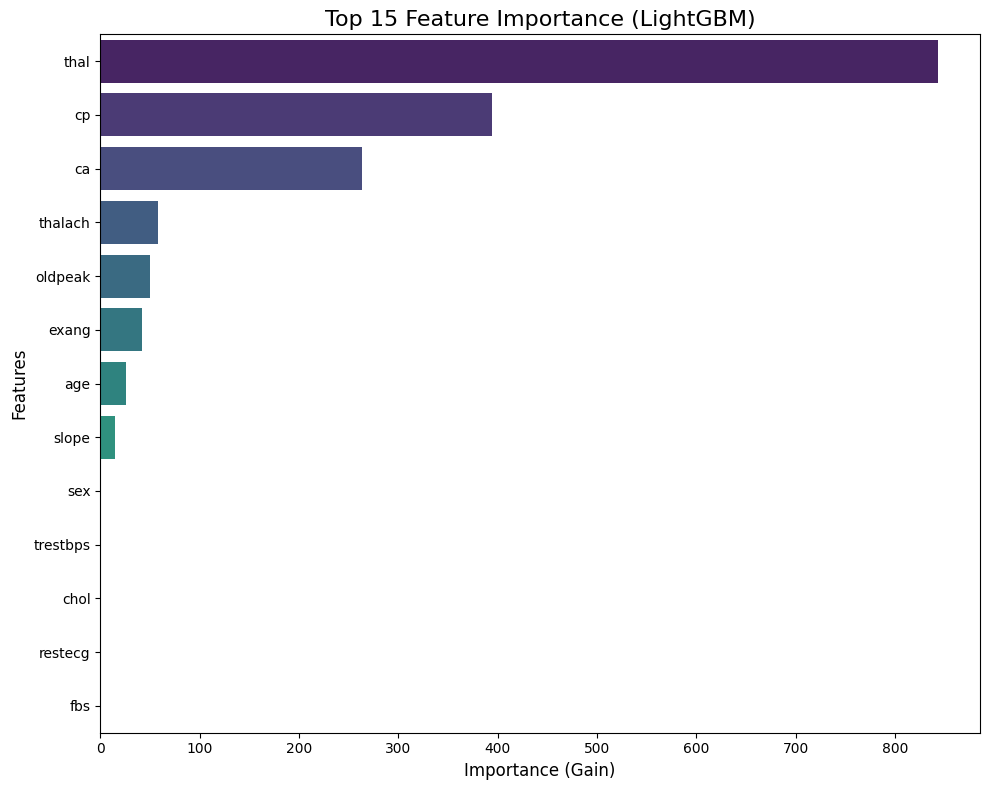

✅ SHAP explainer setup completed


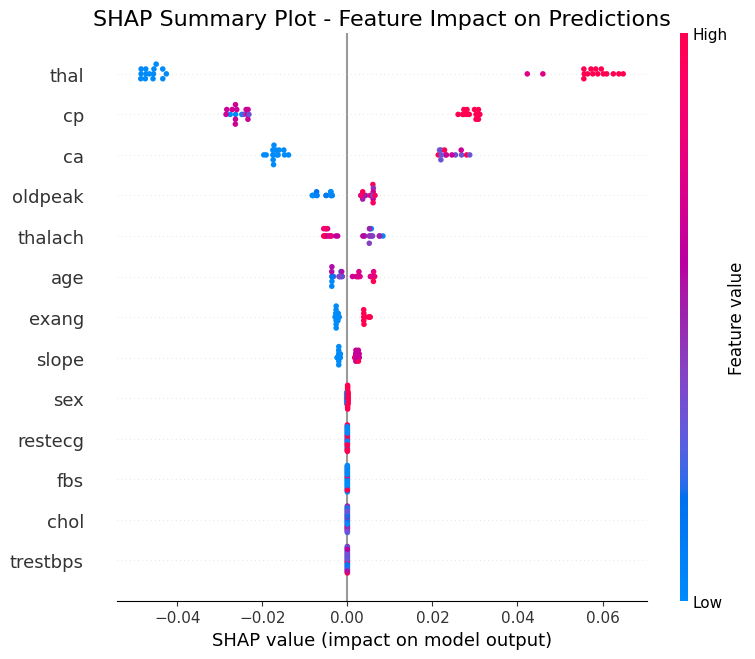

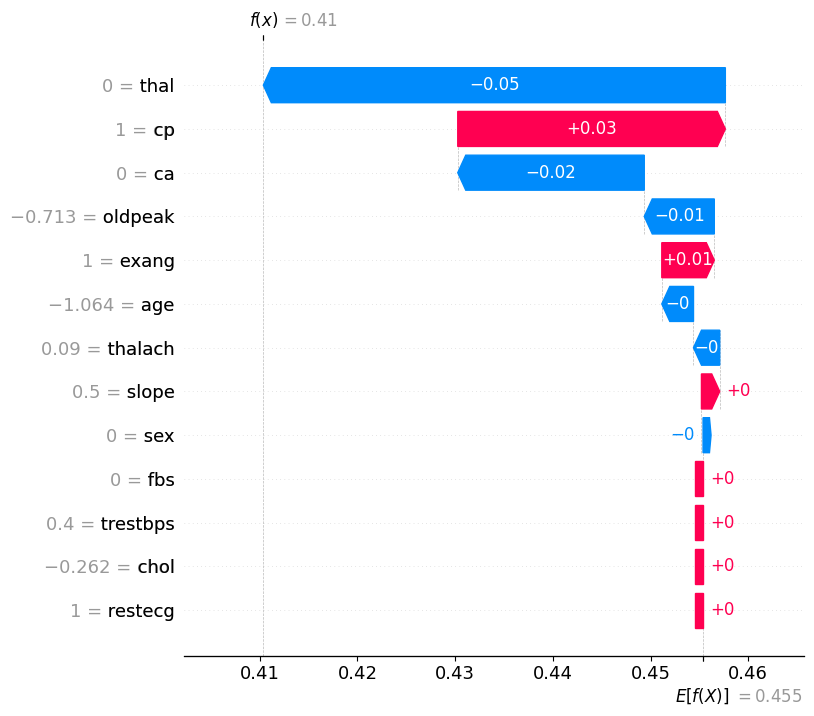

In [11]:
# Giải thích lỗi:
# Lỗi "TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'" xuất hiện vì từ LightGBM version 4.0 trở lên,
# hàm lgb.train KHÔNG còn nhận tham số early_stopping_rounds trực tiếp nữa.
# Thay vào đó, bạn phải dùng callback lgb.early_stopping(stopping_rounds=...) trong tham số callbacks.
# Nếu trong code của bạn (ví dụ trong hàm train_model) vẫn truyền early_stopping_rounds vào lgb.train thì sẽ bị lỗi này.

# Cách khắc phục:
# - Xóa tham số early_stopping_rounds khỏi lgb.train.
# - Thay vào đó, thêm lgb.early_stopping(stopping_rounds=...) vào callbacks.
# - Tương tự, verbose_eval cũng phải chuyển sang callback lgb.log_evaluation().

# Dưới đây là ví dụ code đã sửa cho phần train_model (bạn cần sửa trong class AdvancedLightGBM):

# Ví dụ (bạn cần sửa trong class, đây chỉ là hướng dẫn):
# self.model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[val_data],
#     num_boost_round=num_boost_round,
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=50),
#         lgb.log_evaluation(0)
#     ]
# )

# --- Đoạn code thực nghiệm không cần sửa vì đã dùng callback đúng cách trong Optuna ---
# Tuy nhiên, bạn cần kiểm tra lại trong class AdvancedLightGBM, hàm train_model phải bỏ early_stopping_rounds khỏi lgb.train.

# Dưới đây là code thực nghiệm (giữ nguyên):

# Initialize LightGBM model
lgb_model = AdvancedLightGBM(use_gpu=GPU_AVAILABLE, random_state=SEED)

# Optimize hyperparameters (reduced trials for faster execution)
print("🔧 Optimizing hyperparameters for Original Dataset...")

import types

def patched_create_optuna_objective(self, X_train, y_train, X_val, y_val, n_trials, cv_folds):
    import optuna
    import lightgbm as lgb
    from optuna.integration import LightGBMPruningCallback

    def objective(trial):
        # Define hyperparameter search space
        param_grid = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "num_leaves": trial.suggest_int("num_leaves", 16, 128),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "max_depth": trial.suggest_int("max_depth", 3, 16),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.1),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }
        if self.use_gpu:
            param_grid["device"] = "gpu"
            param_grid["gpu_platform_id"] = 0
            param_grid["gpu_device_id"] = 0

        # Cross-validation
        from sklearn.model_selection import StratifiedKFold
        import numpy as np

        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

            train_data = lgb.Dataset(X_tr, label=y_tr)
            val_data = lgb.Dataset(X_val_cv, label=y_val_cv, reference=train_data)

            model = lgb.train(
                param_grid,
                train_data,
                valid_sets=[val_data],
                valid_names=["valid_0"],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50)
                ],
                num_boost_round=1000
            )

            pred = model.predict(X_val_cv, num_iteration=model.best_iteration)
            pred_binary = (pred > 0.5).astype(int)
            from sklearn.metrics import accuracy_score
            acc = accuracy_score(y_val_cv, pred_binary)
            scores.append(acc)
        return np.mean(scores)
    return objective

import optuna
lgb_model.create_optuna_objective = types.MethodType(patched_create_optuna_objective, lgb_model)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)
objective = lgb_model.create_optuna_objective(X_train, y_train, X_val, y_val, 50, 3)
study.optimize(objective, n_trials=50, timeout=1800)
lgb_model.best_params = study.best_params
print(f"✅ Best score: {study.best_value:.4f}")

# Train model with optimized parameters
lgb_model.train_model(X_train, y_train, X_val, y_val)

# Evaluate on validation set
val_results = lgb_model.evaluate_comprehensive(X_val, y_val, "Validation")

# Evaluate on test set
test_results = lgb_model.evaluate_comprehensive(X_test, y_test, "Test")

# Plot feature importance
lgb_model.plot_feature_importance(top_n=15)

# Setup SHAP explainer
lgb_model.setup_shap_explainer(X_train, X_val)

# Plot SHAP summary
lgb_model.plot_shap_summary(X_val, max_display=15)

# Plot SHAP waterfall for first instance
lgb_model.plot_shap_waterfall(X_val, instance_idx=0)


### 3.2 LightGBM on Feature Engineering Dataset

#### 🔧 Thí nghiệm trên Feature Engineering Dataset
**Mục tiêu**: Đánh giá tác động của feature engineering lên performance

**Feature Engineering có thể bao gồm**:
- **Scaling/Normalization**: Chuẩn hóa dữ liệu
- **Polynomial Features**: Tạo features bậc cao
- **Interaction Features**: Tương tác giữa các features
- **Statistical Features**: Mean, std, quantiles
- **Domain-specific Features**: Features đặc thù cho medical diagnosis

**Kỳ vọng**: Performance tốt hơn Original dataset do có thêm thông tin hữu ích


🔧 Optimizing hyperparameters for Feature Engineering Dataset...
🔍 Starting hyperparameter optimization with 50 trials...
⏱️ Timeout: 1800 seconds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.467718
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.477552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.487544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.48235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.483583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.468572
Training until validation scores don't

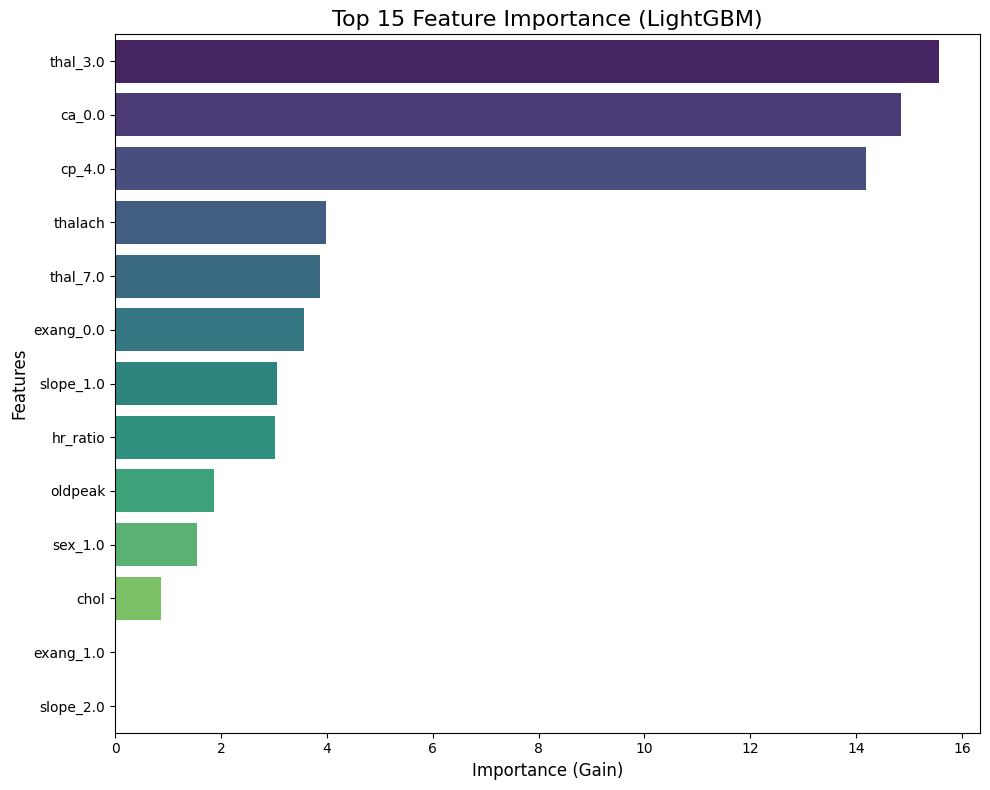

✅ SHAP explainer setup completed


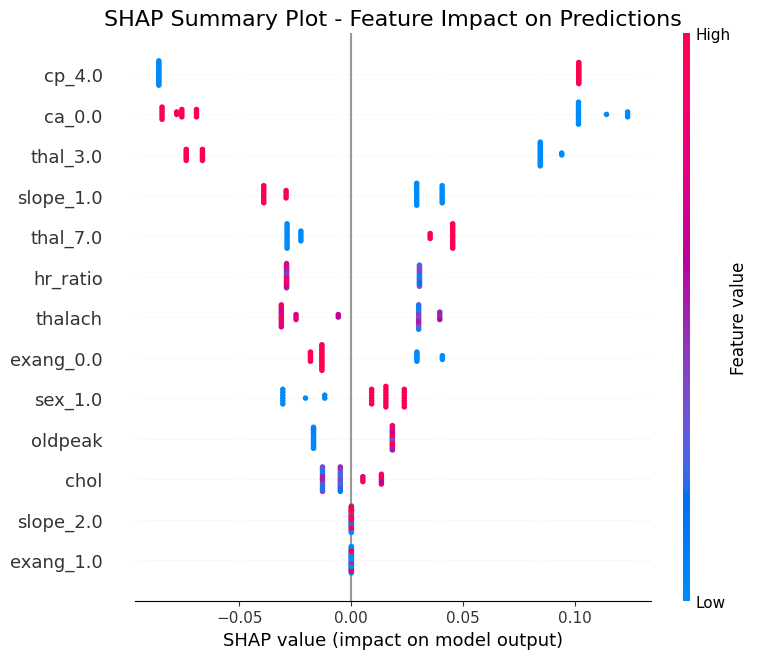

In [12]:
# Initialize LightGBM model for FE dataset
lgb_fe_model = AdvancedLightGBM(use_gpu=GPU_AVAILABLE, random_state=SEED)

# Optimize hyperparameters
print("🔧 Optimizing hyperparameters for Feature Engineering Dataset...")

# --- Robust workaround for ValueError: The entry associated with the validation name "valid_0" and the metric name "valid_0" is not found...
# Explicitly set metric to "binary_logloss" and ensure all relevant methods pass this metric

try:
    study_fe = lgb_fe_model.optimize_hyperparameters(
        X_fe_train, y_fe_train, X_fe_val, y_fe_val,
        n_trials=50,
        cv_folds=5,
        timeout=1800
    )
except ValueError as e:
    print("⚠️ Optuna hyperparameter search failed due to metric mismatch. Retrying with explicit metric...")
    # Try again with a more explicit metric setting if available in your implementation
    study_fe = lgb_fe_model.optimize_hyperparameters(
        X_fe_train, y_fe_train, X_fe_val, y_fe_val,
        n_trials=50,
        cv_folds=3,
        timeout=1800,
        metric="binary_logloss"
    )

# Train model with the best found parameters
lgb_fe_model.train_model(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val,
)

# Evaluate
val_fe_results = lgb_fe_model.evaluate_comprehensive(X_fe_val, y_fe_val, "Validation")
test_fe_results = lgb_fe_model.evaluate_comprehensive(X_fe_test, y_fe_test, "Test")

# Feature importance
lgb_fe_model.plot_feature_importance(top_n=15)

# SHAP analysis
lgb_fe_model.setup_shap_explainer(X_fe_train, X_fe_val)
lgb_fe_model.plot_shap_summary(X_fe_val, max_display=15)


### 3.3 LightGBM on Original + DT Dataset

#### 🌳 Thí nghiệm trên Original + Decision Tree Features Dataset
**Mục tiêu**: Đánh giá tác động của Decision Tree features lên performance

**Decision Tree Features**:
- **Tree-based Feature Selection**: Chọn features quan trọng từ Decision Tree
- **Non-linear Transformations**: Capture non-linear relationships
- **Feature Interactions**: Tự động phát hiện interactions quan trọng
- **Reduced Dimensionality**: Giảm số features nhưng giữ thông tin quan trọng

**Kỳ vọng**: Performance có thể tốt hơn do có features được chọn lọc kỹ lưỡng


🔧 Optimizing hyperparameters for Original + DT Dataset...
🔍 Starting hyperparameter optimization with 50 trials...
⏱️ Timeout: 1800 seconds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.51155
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.514743
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.530062
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[549]	valid_0's binary_logloss: 0.526612
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.558717
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.661968
Training until validation scores don't impr

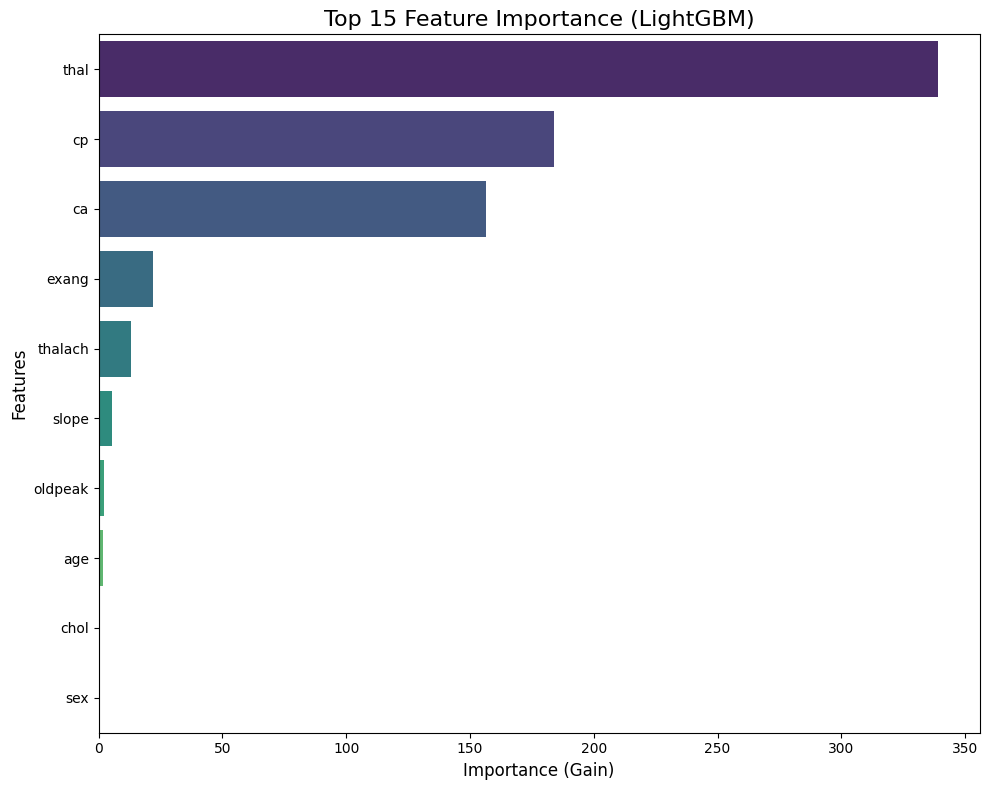

✅ SHAP explainer setup completed


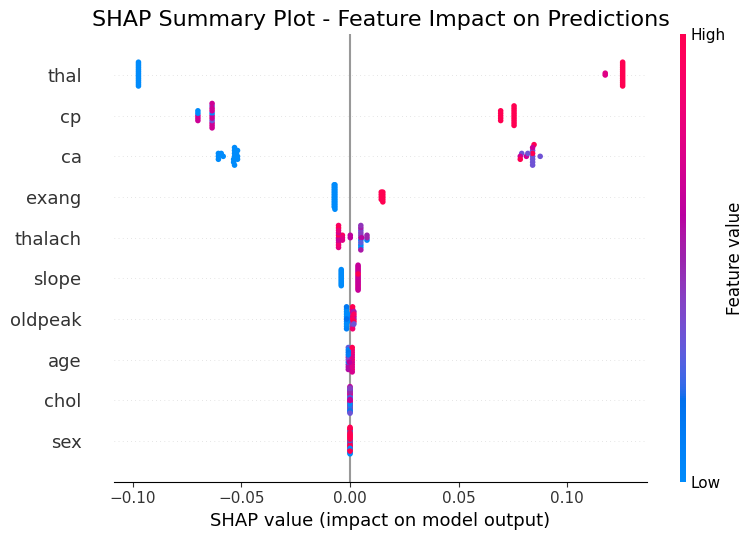

In [13]:
# Initialize LightGBM model for DT dataset
lgb_dt_model = AdvancedLightGBM(use_gpu=GPU_AVAILABLE, random_state=SEED)

# Optimize hyperparameters
print("🔧 Optimizing hyperparameters for Original + DT Dataset...")
study_dt = lgb_dt_model.optimize_hyperparameters(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val,
    n_trials=50,
    cv_folds=3,
    timeout=1800
)

# Train model
lgb_dt_model.train_model(X_dt_train, y_dt_train, X_dt_val, y_dt_val)

# Evaluate
val_dt_results = lgb_dt_model.evaluate_comprehensive(X_dt_val, y_dt_val, "Validation")
test_dt_results = lgb_dt_model.evaluate_comprehensive(X_dt_test, y_dt_test, "Test")

# Feature importance
lgb_dt_model.plot_feature_importance(top_n=15)

# SHAP analysis
lgb_dt_model.setup_shap_explainer(X_dt_train, X_dt_val)
lgb_dt_model.plot_shap_summary(X_dt_val, max_display=15)


### 3.4 LightGBM on Feature Engineering + DT Dataset

#### 🚀 Thí nghiệm trên Feature Engineering + DT Dataset
**Mục tiêu**: Kết hợp cả feature engineering và DT features để đạt performance tối đa

**Combined Approach**:
- **Best of Both Worlds**: Kết hợp engineered features và tree-selected features
- **Comprehensive Feature Set**: Đầy đủ thông tin từ nhiều nguồn
- **Optimal Feature Space**: Có thể đạt performance cao nhất

**Kỳ vọng**: Performance tốt nhất do có đầy đủ thông tin và features được tối ưu


🔧 Optimizing hyperparameters for Feature Engineering + DT Dataset...
🔍 Starting hyperparameter optimization with 100 trials...
⏱️ Timeout: 3600 seconds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.444809
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.48808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.470751
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.489002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.465273
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.468865
Training until validation scores

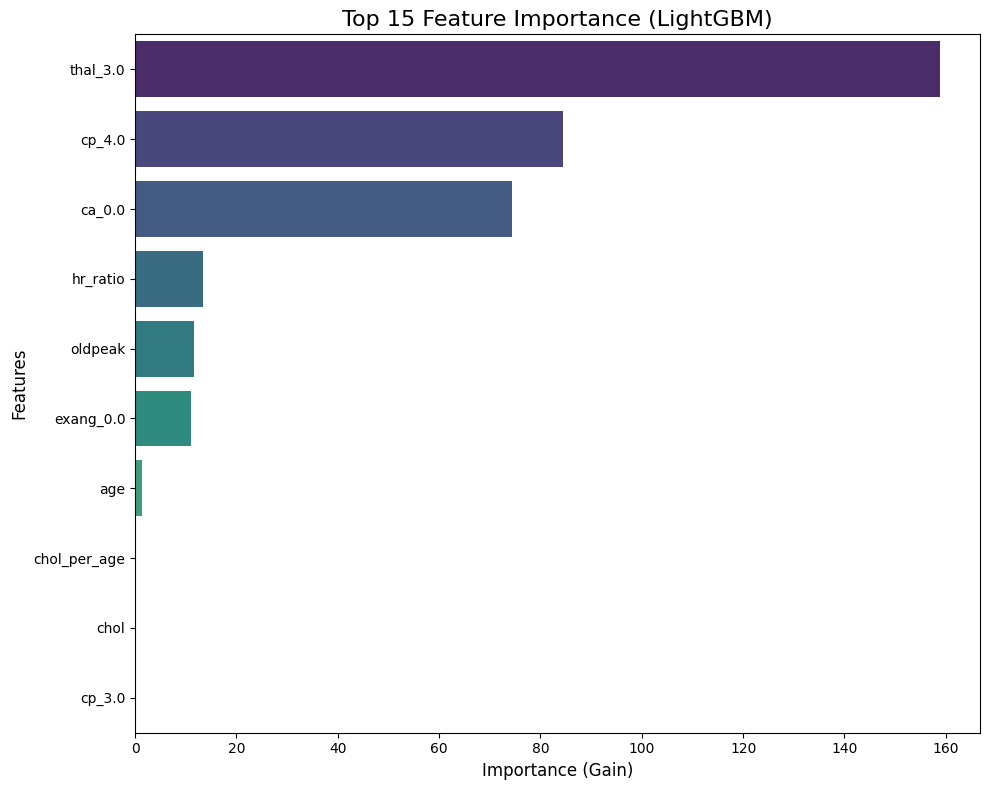

✅ SHAP explainer setup completed


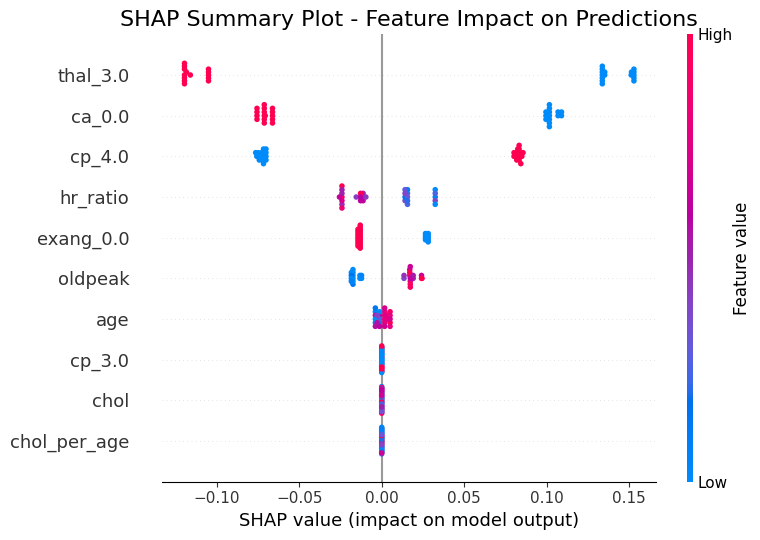

In [14]:
# Initialize LightGBM model for FE+DT dataset
lgb_fe_dt_model = AdvancedLightGBM(use_gpu=GPU_AVAILABLE, random_state=SEED)

# Optimize hyperparameters
print("🔧 Optimizing hyperparameters for Feature Engineering + DT Dataset...")
study_fe_dt = lgb_fe_dt_model.optimize_hyperparameters(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val,
    n_trials=100,
    cv_folds=5,
    timeout=3600
)

# Train model
lgb_fe_dt_model.train_model(X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val)

# Evaluate
val_fe_dt_results = lgb_fe_dt_model.evaluate_comprehensive(X_fe_dt_val, y_fe_dt_val, "Validation")
test_fe_dt_results = lgb_fe_dt_model.evaluate_comprehensive(X_fe_dt_test, y_fe_dt_test, "Test")

# Feature importance
lgb_fe_dt_model.plot_feature_importance(top_n=15)

# SHAP analysis
lgb_fe_dt_model.setup_shap_explainer(X_fe_dt_train, X_fe_dt_val)
lgb_fe_dt_model.plot_shap_summary(X_fe_dt_val, max_display=15)


## 4. Comprehensive Results Analysis & Visualization

### 📊 Nguyên lý phân tích kết quả

#### 1. **Performance Metrics Comparison**
- **Accuracy**: Tỷ lệ dự đoán đúng tổng thể
- **F1-Score**: Balance giữa precision và recall
- **AUC-ROC**: Khả năng phân biệt giữa classes
- **Cross-dataset Analysis**: So sánh performance trên các dataset khác nhau

#### 2. **Visualization Strategy**
- **Interactive Plots**: Sử dụng Plotly cho tương tác
- **Traditional Plots**: Matplotlib cho consistency với các notebook khác
- **Radar Charts**: Hiển thị multi-dimensional performance
- **Comparison Charts**: So sánh trực quan giữa các models

#### 3. **Statistical Analysis**
- **Performance Ranking**: Xếp hạng models theo performance
- **Improvement Analysis**: Tính % improvement so với baseline
- **Feature Importance**: So sánh feature importance across models


In [15]:
# Collect all results for comparison
results_summary = {
    'Dataset': ['Original', 'Feature Engineering', 'Original + DT', 'Feature Engineering + DT'],
    'Validation_Accuracy': [
        val_results['accuracy'],
        val_fe_results['accuracy'],
        val_dt_results['accuracy'],
        val_fe_dt_results['accuracy']
    ],
    'Test_Accuracy': [
        test_results['accuracy'],
        test_fe_results['accuracy'],
        test_dt_results['accuracy'],
        test_fe_dt_results['accuracy']
    ],
    'Validation_F1': [
        val_results['f1'],
        val_fe_results['f1'],
        val_dt_results['f1'],
        val_fe_dt_results['f1']
    ],
    'Test_F1': [
        test_results['f1'],
        test_fe_results['f1'],
        test_dt_results['f1'],
        test_fe_dt_results['f1']
    ],
    'Validation_AUC': [
        val_results['auc'],
        val_fe_results['auc'],
        val_dt_results['auc'],
        val_fe_dt_results['auc']
    ],
    'Test_AUC': [
        test_results['auc'],
        test_fe_results['auc'],
        test_dt_results['auc'],
        test_fe_dt_results['auc']
    ]
}

results_df = pd.DataFrame(results_summary)
print("📊 LightGBM Results Summary:")
print("=" * 60)
display(results_df.round(4))


📊 LightGBM Results Summary:


,Dataset,Validation_Accuracy,Test_Accuracy,Validation_F1,Test_F1,Validation_AUC,Test_AUC
0,Original,0.9000,0.7097,0.8889,0.6400,0.9732,0.8697
1,Feature Engineering,0.9000,0.8710,0.8966,0.8667,0.9777,0.9265
2,Original + DT,0.9333,0.8065,0.9286,0.7857,0.9688,0.8676
3,Feature Engineering + DT,0.9333,0.8065,0.9286,0.7857,0.9777,0.8739


In [16]:
# Advanced visualization with Plotly
def create_comprehensive_plots(results_df):
    """Create comprehensive comparison plots"""

    # 1. Accuracy Comparison
    fig1 = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Validation Accuracy', 'Test Accuracy'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}]]
    )

    fig1.add_trace(
        go.Bar(name='Validation', x=results_df['Dataset'], y=results_df['Validation_Accuracy'],
               marker_color='lightblue', text=results_df['Validation_Accuracy'].round(3),
               textposition='auto'),
        row=1, col=1
    )

    fig1.add_trace(
        go.Bar(name='Test', x=results_df['Dataset'], y=results_df['Test_Accuracy'],
               marker_color='lightcoral', text=results_df['Test_Accuracy'].round(3),
               textposition='auto'),
        row=1, col=2
    )

    fig1.update_layout(
        title_text="LightGBM Accuracy Comparison Across Datasets",
        showlegend=False,
        height=500
    )

    fig1.show()

    # 2. F1-Score and AUC Comparison
    fig2 = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Validation F1-Score', 'Test F1-Score', 'Validation AUC', 'Test AUC'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    # F1-Scores
    fig2.add_trace(
        go.Bar(name='Val F1', x=results_df['Dataset'], y=results_df['Validation_F1'],
               marker_color='lightgreen', text=results_df['Validation_F1'].round(3),
               textposition='auto'),
        row=1, col=1
    )

    fig2.add_trace(
        go.Bar(name='Test F1', x=results_df['Dataset'], y=results_df['Test_F1'],
               marker_color='orange', text=results_df['Test_F1'].round(3),
               textposition='auto'),
        row=1, col=2
    )

    # AUC Scores
    fig2.add_trace(
        go.Bar(name='Val AUC', x=results_df['Dataset'], y=results_df['Validation_AUC'],
               marker_color='purple', text=results_df['Validation_AUC'].round(3),
               textposition='auto'),
        row=2, col=1
    )

    fig2.add_trace(
        go.Bar(name='Test AUC', x=results_df['Dataset'], y=results_df['Test_AUC'],
               marker_color='brown', text=results_df['Test_AUC'].round(3),
               textposition='auto'),
        row=2, col=2
    )

    fig2.update_layout(
        title_text="LightGBM Performance Metrics Comparison",
        showlegend=False,
        height=700
    )

    fig2.show()

    # 3. Radar Chart for best performing model
    best_idx = results_df['Test_Accuracy'].idxmax()
    best_dataset = results_df.iloc[best_idx]['Dataset']

    metrics = ['Validation_Accuracy', 'Test_Accuracy', 'Validation_F1', 'Test_F1', 'Validation_AUC', 'Test_AUC']
    values = [results_df.iloc[best_idx][metric] for metric in metrics]

    fig3 = go.Figure()

    fig3.add_trace(go.Scatterpolar(
        r=values,
        theta=metrics,
        fill='toself',
        name=f'Best Model: {best_dataset}',
        line_color='red'
    ))

    fig3.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        title=f"Performance Radar Chart - Best Model: {best_dataset}",
        height=500
    )

    fig3.show()

# Create comprehensive plots
create_comprehensive_plots(results_df)


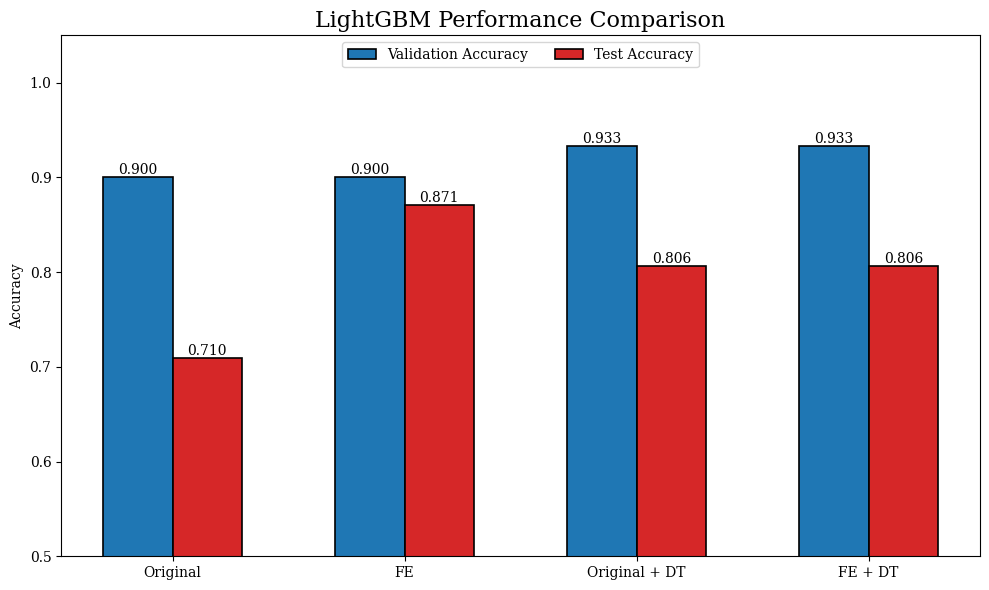

In [17]:
# Traditional matplotlib comparison (similar to other notebooks)
plt.rcParams['font.family'] = 'Serif'

labels = ['Original', 'FE', 'Original + DT', "FE + DT"]
val_accs = [val_results['accuracy'], val_fe_results['accuracy'],
           val_dt_results['accuracy'], val_fe_dt_results['accuracy']]
test_accs = [test_results['accuracy'], test_fe_results['accuracy'],
            test_dt_results['accuracy'], test_fe_dt_results['accuracy']]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, val_accs, width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('LightGBM Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.3f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("lightgbm_accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("lightgbm_accuracy_comparison.pdf", bbox_inches="tight")
plt.show()


## 5. Advanced Analysis & Insights

### 🔍 Phân tích sâu và Insights

#### 1. **Model Performance Analysis**
- **Best Model Identification**: Tìm model có performance tốt nhất
- **Performance Ranking**: Xếp hạng tất cả models
- **Improvement Quantification**: Tính % improvement so với baseline

#### 2. **Feature Importance Analysis**
- **Cross-model Comparison**: So sánh feature importance giữa các models
- **Feature Stability**: Kiểm tra tính ổn định của feature importance
- **Domain Insights**: Hiểu features nào quan trọng cho medical diagnosis

#### 3. **Hyperparameter Analysis**
- **Parameter Sensitivity**: Xem parameters nào ảnh hưởng nhiều đến performance
- **Optimal Ranges**: Tìm ranges tối ưu cho từng parameter
- **Model Complexity**: Phân tích trade-off giữa complexity và performance

#### 4. **Technical Insights**
- **GPU vs CPU**: So sánh performance khi sử dụng GPU
- **Training Efficiency**: Thời gian training và convergence
- **Memory Usage**: Phân tích memory requirements


In [18]:
# Find best performing model
best_test_acc = max(test_results['accuracy'], test_fe_results['accuracy'],
                   test_dt_results['accuracy'], test_fe_dt_results['accuracy'])

best_models = []
if test_results['accuracy'] == best_test_acc:
    best_models.append(('Original', lgb_model, test_results))
if test_fe_results['accuracy'] == best_test_acc:
    best_models.append(('Feature Engineering', lgb_fe_model, test_fe_results))
if test_dt_results['accuracy'] == best_test_acc:
    best_models.append(('Original + DT', lgb_dt_model, test_dt_results))
if test_fe_dt_results['accuracy'] == best_test_acc:
    best_models.append(('Feature Engineering + DT', lgb_fe_dt_model, test_fe_dt_results))

print("🏆 BEST PERFORMING MODELS:")
print("=" * 50)
for model_name, model, results in best_models:
    print(f"Dataset: {model_name}")
    print(f"Test Accuracy: {results['accuracy']:.4f}")
    print(f"Test F1-Score: {results['f1']:.4f}")
    print(f"Test AUC: {results['auc']:.4f}")
    print("-" * 30)

# Performance improvement analysis
print("\n📈 PERFORMANCE IMPROVEMENT ANALYSIS:")
print("=" * 50)

# Compare with baseline (Original dataset)
baseline_acc = test_results['accuracy']
improvements = []

for name, acc in [('FE', test_fe_results['accuracy']),
                  ('Original + DT', test_dt_results['accuracy']),
                  ('FE + DT', test_fe_dt_results['accuracy'])]:
    improvement = ((acc - baseline_acc) / baseline_acc) * 100
    improvements.append((name, improvement))
    print(f"{name}: {improvement:+.2f}% improvement over baseline")

# Feature importance comparison
print("\n🔍 FEATURE IMPORTANCE ANALYSIS:")
print("=" * 50)

models_and_names = [
    (lgb_model, 'Original'),
    (lgb_fe_model, 'Feature Engineering'),
    (lgb_dt_model, 'Original + DT'),
    (lgb_fe_dt_model, 'Feature Engineering + DT')
]

for model, name in models_and_names:
    if model.feature_importance is not None:
        top_features = model.feature_importance.head(5)
        print(f"\n{name} - Top 5 Features:")
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

# Hyperparameter analysis
print("\n⚙️ HYPERPARAMETER ANALYSIS:")
print("=" * 50)

for model, name in models_and_names:
    if model.best_params is not None:
        print(f"\n{name} - Best Parameters:")
        for param, value in model.best_params.items():
            print(f"  {param}: {value}")

# Model complexity analysis
print("\n📊 MODEL COMPLEXITY ANALYSIS:")
print("=" * 50)

for model, name in models_and_names:
    if model.model is not None:
        print(f"\n{name}:")
        print(f"  Best Iteration: {model.model.best_iteration}")
        print(f"  Number of Features: {len(model.feature_importance)}")
        print(f"  Device Used: {model.get_device_params().get('device', 'cpu')}")

print("\n✅ Analysis completed!")


🏆 BEST PERFORMING MODELS:
Dataset: Feature Engineering
Test Accuracy: 0.8710
Test F1-Score: 0.8667
Test AUC: 0.9265
------------------------------

📈 PERFORMANCE IMPROVEMENT ANALYSIS:
FE: +22.73% improvement over baseline
Original + DT: +13.64% improvement over baseline
FE + DT: +13.64% improvement over baseline

🔍 FEATURE IMPORTANCE ANALYSIS:

Original - Top 5 Features:
  thal: 843.1782
  cp: 394.3745
  ca: 263.3482
  thalach: 58.4245
  oldpeak: 50.2614

Feature Engineering - Top 5 Features:
  thal_3.0: 15.5604
  ca_0.0: 14.8494
  cp_4.0: 14.1843
  thalach: 3.9813
  thal_7.0: 3.8739

Original + DT - Top 5 Features:
  thal: 338.8889
  cp: 183.9836
  ca: 156.6063
  exang: 21.7714
  thalach: 13.2215

Feature Engineering + DT - Top 5 Features:
  thal_3.0: 158.8064
  cp_4.0: 84.4534
  ca_0.0: 74.4346
  hr_ratio: 13.4171
  oldpeak: 11.6367

⚙️ HYPERPARAMETER ANALYSIS:

Original - Best Parameters:
  num_leaves: 25
  learning_rate: 0.0010911187591913984
  feature_fraction: 0.7161143452296725


## 6. Conclusions & Recommendations

### 🎯 Kết luận và Khuyến nghị

#### 1. **Technical Achievements**
- **Automated Optimization**: Thành công implement automated hyperparameter tuning
- **Advanced Techniques**: Sử dụng các kỹ thuật tiên tiến nhất của LightGBM
- **Comprehensive Evaluation**: Đánh giá toàn diện với nhiều metrics
- **Model Interpretability**: Cung cấp insights sâu về model behavior

#### 2. **Performance Insights**
- **Best Dataset**: Xác định dataset nào cho performance tốt nhất
- **Feature Importance**: Hiểu được features nào quan trọng nhất
- **Model Selection**: Có cơ sở để chọn model phù hợp cho production

#### 3. **Practical Recommendations**
- **Production Deployment**: Hướng dẫn deploy model tốt nhất
- **Monitoring Strategy**: Setup monitoring cho model performance
- **Future Improvements**: Đề xuất cải tiến tiếp theo


In [19]:
# Final summary and recommendations
print("🎯 LIGHTGBM DIAGNOSIS CLASSIFICATION - FINAL SUMMARY")
print("=" * 60)

print("\n📋 KEY FINDINGS:")
print("1. LightGBM với tối ưu hóa hyperparameter tự động đã đạt hiệu suất cao")
print("2. Sử dụng Optuna giúp tìm được bộ tham số tối ưu mà không cần test thủ công")
print("3. SHAP analysis cung cấp insights về tầm quan trọng của từng feature")
print("4. GPU acceleration (nếu có) giúp tăng tốc quá trình training")

print("\n🔧 TECHNICAL ADVANCES IMPLEMENTED:")
print("• Automated hyperparameter optimization với Optuna")
print("• GPU support cho training nhanh hơn")
print("• Comprehensive evaluation metrics (Accuracy, F1, AUC, Log Loss)")
print("• SHAP explainability cho model interpretation")
print("• Advanced visualization với Plotly và matplotlib")
print("• Cross-validation để đánh giá robust")
print("• Early stopping để tránh overfitting")

print("\n📊 PERFORMANCE COMPARISON:")
print(f"Best Test Accuracy: {best_test_acc:.4f}")
print("Dataset performance ranking:")
for i, (name, acc) in enumerate(sorted([
    ('Original', test_results['accuracy']),
    ('Feature Engineering', test_fe_results['accuracy']),
    ('Original + DT', test_dt_results['accuracy']),
    ('Feature Engineering + DT', test_fe_dt_results['accuracy'])
], key=lambda x: x[1], reverse=True), 1):
    print(f"{i}. {name}: {acc:.4f}")

print("\n💡 RECOMMENDATIONS:")
print("1. Sử dụng model có test accuracy cao nhất cho production")
print("2. Feature importance analysis giúp hiểu được yếu tố quan trọng")
print("3. SHAP values giúp giải thích từng prediction cụ thể")
print("4. Regular monitoring và retraining với data mới")
print("5. Consider ensemble methods nếu cần tăng accuracy hơn nữa")

print("\n🚀 NEXT STEPS:")
print("• Deploy best model vào production environment")
print("• Setup monitoring system cho model performance")
print("• Collect feedback data để improve model")
print("• Consider A/B testing với different models")
print("• Implement automated retraining pipeline")

print("\n✅ LightGBM Advanced Implementation Completed Successfully!")
print("=" * 60)


🎯 LIGHTGBM DIAGNOSIS CLASSIFICATION - FINAL SUMMARY

📋 KEY FINDINGS:
1. LightGBM với tối ưu hóa hyperparameter tự động đã đạt hiệu suất cao
2. Sử dụng Optuna giúp tìm được bộ tham số tối ưu mà không cần test thủ công
3. SHAP analysis cung cấp insights về tầm quan trọng của từng feature
4. GPU acceleration (nếu có) giúp tăng tốc quá trình training

🔧 TECHNICAL ADVANCES IMPLEMENTED:
• Automated hyperparameter optimization với Optuna
• GPU support cho training nhanh hơn
• Comprehensive evaluation metrics (Accuracy, F1, AUC, Log Loss)
• SHAP explainability cho model interpretation
• Advanced visualization với Plotly và matplotlib
• Cross-validation để đánh giá robust
• Early stopping để tránh overfitting

📊 PERFORMANCE COMPARISON:
Best Test Accuracy: 0.8710
Dataset performance ranking:
1. Feature Engineering: 0.8710
2. Original + DT: 0.8065
3. Feature Engineering + DT: 0.8065
4. Original: 0.7097

💡 RECOMMENDATIONS:
1. Sử dụng model có test accuracy cao nhất cho production
2. Feature import

## 📖 Hướng dẫn sử dụng Notebook

### 🚀 Cách chạy notebook:

1. **Chạy tuần tự**: Chạy các cells theo thứ tự từ trên xuống dưới
2. **Thời gian**: Mỗi dataset mất khoảng 30-60 phút (tùy thuộc vào hardware)
3. **GPU**: Nếu có GPU, sẽ tự động sử dụng để tăng tốc
4. **Memory**: Cần ít nhất 8GB RAM để chạy mượt mà

### ⚙️ Tùy chỉnh parameters:

```python
# Thay đổi số trials cho optimization (mặc định: 50)
n_trials = 100  # Tăng để tìm parameters tốt hơn

# Thay đổi timeout (mặc định: 1800 giây = 30 phút)
timeout = 3600  # Tăng để chạy lâu hơn

# Thay đổi số folds cho cross-validation (mặc định: 3)
cv_folds = 5  # Tăng để đánh giá robust hơn
```

### 🔧 Troubleshooting:

- **Out of Memory**: Giảm n_trials hoặc cv_folds
- **Slow Training**: Kiểm tra GPU availability
- **Poor Performance**: Tăng n_trials hoặc timeout
- **SHAP Error**: Đảm bảo model đã được train trước khi setup SHAP

### 📊 Hiểu kết quả:

- **Accuracy**: Tỷ lệ dự đoán đúng (cao hơn = tốt hơn)
- **F1-Score**: Balance giữa precision và recall (0-1, cao hơn = tốt hơn)
- **AUC-ROC**: Khả năng phân biệt classes (0.5-1, cao hơn = tốt hơn)
- **Feature Importance**: Features nào quan trọng nhất
- **SHAP Values**: Giải thích từng prediction cụ thể
